# Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import itertools
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from utils import *
import json, os

# filter warnings
import warnings
warnings.filterwarnings("ignore")

seed=123

# Grid search

**Split dataset into 1-dimensional subsets**

First, the time series is divided into three subsets: train, validation and test. The train dataset is used to train the models, validation to tune their hyperparameters while training and test to study the generalization capability of the network.


**Scale** 

In order for the network to capture the information correctly, the data must be normalized. To do this, the maximum (max_train) and minimum (min_train) values of train are taken and the following scaling formula is applied to each value of the series:

$$(x - max\_train) / (max\_train) - min\_train)$$

where $x$ can be any observation of any subset (train, validation or test). 
 

**Make dataset 2-dimensional**

The infected series is a univariate series, that is, a one-dimensional vector. The task of the neural network is to find the relationship of a series of input values $X$ with output values $Y$: $f(X)=Y$. It is therefore necessary to transform the available univariate series into input vectors $X$ related to output vectors $Y$ that maintain the temporal sense. In this sense, $X$ is the set of $window\_size$ past observed values and $Y$ is the set of $steps\_ahead$ values to be predicted. The two dimensions of $X$ are characterized by the number of predictors (defined by $window\_size$) and the number of observed time windows; the two dimensions of $Y$ are characterized by the number of $steps\_ahead$ and the number of observed time windows. 

To define some types of networks as LSTM, three dimensions are required, not two: every input to LSTM layer must be three-dimensional, where the dimensions are as follows: [batch, window_size, features].


**Grid Search**

Once the data is prepared, a mesh with hyperparameters is defined. This mesh is excessively large, so a random sample of $max\_configs$ combinations is taken. With each combination, a model is created and evaluated.


**Final notes**

Due to the low complexity of the treated series (it has few observations and is univariate), the series could tend to overfit and simply reproduce the previous data. For this reason, quite aggressive dropouts have been defined in the mesh. 

Define the path to store the results of the grid search.

In [27]:
base_dir = Path(os.getcwd()).parents[0]
path_to_store_results = os.path.join(base_dir, 'data', 'nn-results', 'evaluations')
path_to_save_models = os.path.join(base_dir, 'data', 'nn-results', 'models')

Define the class to perform the parameter search.

In [50]:
class paramsearch:
    """
    Grid search to get the best parameters

    Args:
        data (pd.DataFrame): univariate series with the data
        steps_ahead (int): number of steps ahead to forecast
        hyperparams (dict of lists): dict of hyperparams 
        split_sizes (tuple): sizes of train and validation sets. By default=(0.5,0.2).
                             (test size is 1-(0.5+0.2)=0.3 for default case)
        max_configs (int): max number of combinations to evaluate
        metricas (dict): metrics used in evaluation
    """

    def __init__(self, data, steps_ahead=14, max_configs=100, split_sizes=(0.5, 0.2), hyperparams=None, metrics=metrics):

        # store data
        self.data = data
        self.train_df = None
        self.val_df = None
        self.test_df = None

        # if no grid specified, define grid
        if hyperparams is None:
            self.hyperparams = {
                'window_size': [i for i in range(10, 25)],
                'num_neurons': [i for i in range(5, 20)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.5, 0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
        else:
            self.hyperparams = hyperparams

        # store attributes
        self.steps_ahead = steps_ahead
        self.max_configs = max_configs
        self.train_size = split_sizes[0]
        self.val_size = split_sizes[1]
        self.metrics = metrics
        self.tf_metrics = metrics = [RMSLETF,
                                    'mae', 
                                    tf.keras.metrics.RootMeanSquaredError(), 
                                    tf.keras.metrics.MeanAbsolutePercentageError()]

        # train config
        self.epochs = 100
        self.batch_size = 16

        # vars to store experiment results
        self.history_log = {}
        self.model_log = {}
        self.pandas_log = None
        self.all_data_from_model = {}

    def run_experiment(self, verbose=1):
        # set seed
        np.random.seed(seed)

        # generate grid
        hypergrid = list(self.generate_hypergrid())
        # subsample hypergrid (get only some combinations of hyperparameters)
        hypergrid = self.subsample_hypergrid(hypergrid)

        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)

        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. loop over hypergrid
        for hypercomb in hypergrid:
            try:
                if verbose:
                    print(hypercomb)

                # 3.1. make dataset
                X_train, Y_train = self.make_dataset(
                    window_size=hypercomb['window_size'], series=train_df_sc)
                X_val, Y_val = self.make_dataset(
                    window_size=hypercomb['window_size'], series=val_df_sc)
                X_test, Y_test = self.make_dataset(
                    window_size=hypercomb['window_size'], series=test_df_sc)

                # 3.2. build model
                model = self.build_model(hypercomb['num_layers'],
                                        hypercomb['num_neurons'],
                                        hypercomb['dropouts'],
                                        hypercomb['window_size'],
                                        hypercomb['layer_type'],
                                        hypercomb['activation_function'],
                                        self.tf_metrics)

                # 3.3. train model
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=20,
                                                mode='min')
                history = model.fit(X_train, Y_train, validation_data=(
                    X_val, Y_val), batch_size=self.batch_size, epochs=self.epochs,
                    callbacks=[early_stopping],
                    verbose=0)

                # 3.4. store history in history dict
                self.history_log['_'.join(
                    [str(param) for param in hypercomb.values()])] = history

                # 3.5. store trained model in model dict
                self.model_log['_'.join([str(param)
                                        for param in hypercomb.values()])] = model

                # 3.6. evaluate model on validation set and store results
                result_val = self.evaluate_model(model, X_val, Y_val)
                result_val = {f'val_{k}':v for k,v in result_val.items()}
                # print(result_val)

                # 3.7. evaluate model on test set and store results
                result_test = self.evaluate_model(model, X_test, Y_test)
                result_test = {f'test_{k}':v for k,v in result_test.items()}
                # print(result_test)

                # 3.8. print combination and evaluation results on val and train
                newrow = pd.DataFrame({**hypercomb, **result_val, **result_test})
                # display(newrow)

                # 3.9. store all data from model in dict
                self.store_all_data(hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test)
                # add row to metric table
                if self.pandas_log is None:
                    self.pandas_log = newrow
                else:
                    self.pandas_log = pd.concat([self.pandas_log, newrow])

            except Exception as e:
                print(e)
                continue

    def generate_hypergrid(self):
        """Returns all possible combinations 
            of the hyperparameters"""
        keys = self.hyperparams.keys()
        vals = self.hyperparams.values()
        for instance in itertools.product(*vals):
            yield dict(zip(keys, instance))

    def subsample_hypergrid(self, hypergrid):
        """Returns subsamples of the hypergrid"""
        # get self.max_configs random combinations of hyperparameters combinations
        subsamples = random.sample(range(len(hypergrid)), self.max_configs)
        subsamples = [hypergrid[i] for i in subsamples]
        print(f'Number of configs to evaluate: {len(subsamples)}')
        print('-------------------------------------------------\n')
        return subsamples

    def univariate_train_test_split(self, data):
        """Splits the data into train, val and test sets"""
        # split data into univariate train, val and test sets
        n = len(data)
        train_df = data[:int(n * self.train_size)]
        val_df = data[int(n * self.train_size):int(n * (self.train_size + self.val_size))]
        test_df = data[int(n * (self.train_size + self.val_size)):]
        return train_df, val_df, test_df

    def scale_data(self, data_subset, train_df=None, type='maxmin'):
        """Scales the data into [0,1] """
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            return (data_subset - train_df.min()) / (train_df.max() - train_df.min())
        if type == 'standard':
            return (data_subset - train_df.mean()) / train_df.std()

    def descale_data(self, data_subset, train_df=None, type='maxmin'):
        """Descales the data into original scale"""
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            return data_subset * (train_df.max() - train_df.min()) + train_df.min()
        if type == 'standard':
            return data_subset * train_df.std() + train_df.mean()

    def make_dataset(self, series, window_size=None, steps_ahead=None, dropna=True):
        """Prepare dataset to have two dimensions for X and y"""

        if window_size is None:
            window_size = self.window_size
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # create a dataframe with the data
        series = pd.Series(series.values.ravel(), index=pd.DatetimeIndex(
            series.index), dtype=pd.Int8Dtype)
        # lag features
        X = pd.DataFrame({'t-'+str(i): series.shift(i)
                         for i in range(window_size)})
        # steps ahead targets
        y = pd.DataFrame({'step_'+str(i): series.shift(-i)
                         for i in range(1, steps_ahead+1)})
        # # add the lagged features to the dataframe
        # data = pd.concat({'Features': X.iloc[:,::-1], 'Targets': y}, axis=1)

        # drop nan rows
        if dropna:
            X = X.dropna()
            y = y.dropna()

        # make the index of y and X equal
        y, X = y.align(X, join='inner', axis=0)
        return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')


    def build_layer(self, num_neurons, dropouts, layer_type, activation_function, last=False):
        if not last:
            if layer_type == 'lstm':
                return layers.LSTM(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
        else:
            if layer_type == 'lstm':
                return layers.LSTM(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)

    def build_model(self, num_layers, num_neurons, dropouts, window_size, layer_type, activation_function, metrics=[]):
        model = Sequential()
        model.add(layers.InputLayer(input_shape=(window_size,)))
        model.add(layers.Reshape((window_size, 1)))
        for i in range(num_layers-1):
            model.add(self.build_layer(num_neurons, dropouts,
                      layer_type, activation_function))
        model.add(self.build_layer(num_neurons, dropouts,
                  layer_type, activation_function, last=True))

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3), 
            loss='msle', 
            metrics=metrics)

        return model

    def evaluate_model(self, model, X_data_subset=None, Y_data_subset=None):
        """Evaluates the model on (X_data_subset, Y_data_subset) set
            Those subsets are scaled.
        """
        evaluation = {}

        # 1. generate forecasts
        preds = model.predict(X_data_subset)
        
        # 2. descale the forecasts
        descaled_preds = self.descale_data(preds)
        descaled_Y_data_subset = self.descale_data(
            Y_data_subset)
        # descaled_Y_data_subset = np.asarray(Y_data_subset).astype('float32')

        # 3. evaluate the model per each step_ahead
        for i in range(self.steps_ahead):
            nn_step_evaluation = {}
            # 3.1. evaluate the model on the current step_ahead
            data_subset_step = descaled_Y_data_subset[:, i]
            predicted_step = descaled_preds[:, i]
            # 3.2. evaluate the model on the current step_ahead
            for metric_name, metric in self.metrics.items():
                nn_step_evaluation[metric_name] = metric(
                    data_subset_step, predicted_step)

            evaluation[f'step_{i+1}'] = nn_step_evaluation
        return evaluation

    def get_predictions(self, model, window_size=None):
        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)
            
        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. make dataset
        X_train, Y_train = self.make_dataset(
            window_size=window_size, series=train_df_sc)
        X_val, Y_val = self.make_dataset(
            window_size=window_size, series=val_df_sc)
        X_test, Y_test = self.make_dataset(
            window_size=window_size, series=test_df_sc)

        # 4. make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test)

        # 5. descale the predictions
        train_preds = self.descale_data(train_preds)
        val_preds = self.descale_data(val_preds)
        test_preds = self.descale_data(test_preds)

        # and descale the sets
        Y_train = self.descale_data(Y_train)
        Y_val = self.descale_data(Y_val)
        Y_test = self.descale_data(Y_test)

        # 6. return the predictions
        return Y_train, train_preds, Y_val, val_preds, Y_test, test_preds
    
    def store_all_data(self, hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test):
        results = {}
        key = '_'.join([str(param) for param in hypercomb.values()])
        results['hypercomb'] = hypercomb
        results['X_train'] = self.descale_data(X_train)
        results['Y_train'] = self.descale_data(Y_train)
        results['X_val'] = self.descale_data(X_val)
        results['Y_val'] = self.descale_data(Y_val)
        results['X_test'] = self.descale_data(X_test)
        results['Y_test'] = self.descale_data(Y_test)
        results['train_forecasts'] = self.descale_data(model.predict(X_train))
        results['val_forecasts'] = self.descale_data(model.predict(X_val))
        results['test_forecasts'] = self.descale_data(model.predict(X_test))
        results['result_val'] = result_val
        results['result_test'] = result_test
        self.all_data_from_model[key] = results
        
        # # save dict to disk
        # file_name = os.path.join(path_to_store_results, key)
        # results_df = pd.DataFrame.from_dict(results)
        # results_df.to_csv(file_name + '.csv')

# Data

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\spanish-covid-19-data-renave-07Jul2022.csv


<AxesSubplot:title={'center':'COVID-19 Infected (raw data)'}, xlabel='Date'>

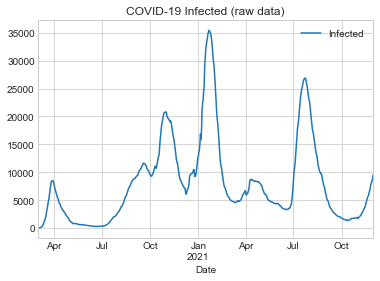

In [52]:
# read data without smoothing
df = load_last_final_data(from_folder='final')
# keep only the infected variable
df = df[['Infected']]
# represent the series
df.plot(title='COVID-19 Infected (raw data)')

In [53]:
# select the variable of interest
serie = df['Infected']

## Instantiate 

In [54]:
hyperparams = {'window_size': [i for i in range(4, 30)],
                'num_neurons': [i for i in range(5, 30)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
                
parasect = paramsearch(serie,max_configs=100, hyperparams=hyperparams)

In [7]:
# run random grid search
parasect.run_experiment()

Number of configs to evaluate: 100
-------------------------------------------------

{'window_size': 7, 'num_neurons': 29, 'num_layers': 3, 'dropouts': 0.8, 'layer_type': 'gru', 'activation_function': 'tanh'}
6/6 [==============================] - 0s 2ms/step
{'window_size': 18, 'num_neurons': 16, 'num_layers': 4, 'dropouts': 0.7, 'layer_type': 'gru', 'activation_function': 'relu'}
6/6 [==============================] - 0s 4ms/step
{'window_size': 7, 'num_neurons': 6, 'num_layers': 3, 'dropouts': 0.7, 'layer_type': 'gru', 'activation_function': 'relu'}
6/6 [==============================] - 0s 2ms/step
{'window_size': 29, 'num_neurons': 28, 'num_layers': 3, 'dropouts': 0.8, 'layer_type': 'gru', 'activation_function': 'tanh'}
5/5 [==============================] - 0s 6ms/step
{'window_size': 25, 'num_neurons': 28, 'num_layers': 3, 'dropouts': 0.6, 'layer_type': 'lstm', 'activation_function': 'tanh'}
5/5 [==============================] - 0s 6ms/step
{'window_size': 21, 'num_neurons': 1

# Check results

In [8]:
# show nn config and its metrics
parasect.pandas_log

window_size  num_neurons  num_layers  dropouts layer_type  \
RMSLE            7           29           3       0.8        gru   
MAE              7           29           3       0.8        gru   
RMSE             7           29           3       0.8        gru   
MAPE             7           29           3       0.8        gru   
RMSLE           18           16           4       0.7        gru   
...            ...          ...         ...       ...        ...   
MAPE            29           26           1       0.6       lstm   
RMSLE           16           10           1       0.8       lstm   
MAE             16           10           1       0.8       lstm   
RMSE            16           10           1       0.8       lstm   
MAPE            16           10           1       0.8       lstm   

      activation_function   val_step_1   val_step_2   val_step_3   val_step_4  \
RMSLE                tanh     0.280872     0.271981     0.265516     0.275594   
MAE                  tanh  2812.068604  2644.171875  2517.007812  2515.460938   
RMSE                 tanh  5511.950684  5162.709473  4904.138184  4747.930664   
MAPE                 tanh     0.194842     0.195739     0.194024     0.211697   
RMSLE                relu     0.848281     0.824763     0.819044     0.810058   
...                   ...          ...          ...          ...          ...   
MAPE                 relu     0.353090     0.391178     0.254702     0.344951   
RMSLE                tanh     0.444602     0.441916     0.443861     0.512400   
MAE                  tanh  3773.238281  3569.346680  3543.039062  4084.234619   
RMSE                 tanh  4313.240723  4145.748047  3974.262207  4749.319336   
MAPE                 tanh     0.514502     0.505623     0.515463     0.614902   

       ...  test_step_5  test_step_6  test_step_7  test_step_8  test_step_9  \
RMSLE  ...     0.667377     0.711591     0.702745     0.737844     0.737615   
MAE    ...  3805.664551  4071.259033  4009.201416  4245.056152  4228.008789   
RMSE   ...  5161.349609  5457.584473  5374.055176  5711.534668  5733.183105   
MAPE   ...     0.791379     0.867076     0.849946     0.901828     0.893212   
RMSLE  ...     0.901430     0.974617     0.865416     0.864058     0.989171   
...    ...          ...          ...          ...          ...          ...   
MAPE   ...     0.606990     0.704939     0.723173     0.830597     0.827673   
RMSLE  ...     0.700411     0.664291     0.761417     0.700628     0.769097   
MAE    ...  4298.324219  4384.704102  4734.777832  4652.838379  4970.100586   
RMSE   ...  5318.693848  5595.691895  5755.373535  5929.426270  6129.650391   
MAPE   ...     0.892873     0.803776     1.013289     0.857029     1.007752   

       test_step_10  test_step_11  test_step_12  test_step_13  test_step_14  
RMSLE      0.768920      0.758955      0.790528      0.806222      0.815262  
MAE     4452.398926   4437.678223   4632.632324   4749.875000   4832.418457  
RMSE    5957.821289   6041.406250   6140.586914   6325.840820   6437.393555  
MAPE       0.951995      0.914374      0.988320      1.007732      1.016739  
RMSLE      0.959329      0.922721      0.902212      0.896425      0.973985  
...             ...           ...           ...           ...           ...  
MAPE       0.644327      0.834343      0.829746      0.772444      0.825739  
RMSLE      0.792067      0.804629      0.799078      0.843517      0.877757  
MAE     5025.957031   5291.612793   5339.982910   5478.257324   5759.227539  
RMSE    6213.362793   6640.950684   6834.363281   6877.575684   7227.083496  
MAPE       1.048046      1.044241      0.988939      1.118821      1.180017  

[296 rows x 34 columns]

In [9]:
# show history from model training
parasect.history_log

{'7_29_3_0.8_gru_tanh': <keras.callbacks.History at 0x1cca63908b0>,
 '18_16_4_0.7_gru_relu': <keras.callbacks.History at 0x1ccb16e92b0>,
 '7_6_3_0.7_gru_relu': <keras.callbacks.History at 0x1ccbb684d00>,
 '29_28_3_0.8_gru_tanh': <keras.callbacks.History at 0x1ccbb33aa90>,
 '25_28_3_0.6_lstm_tanh': <keras.callbacks.History at 0x1ccd049ebe0>,
 '21_19_2_0.7_lstm_tanh': <keras.callbacks.History at 0x1ccdb44c790>,
 '13_24_2_0.7_lstm_tanh': <keras.callbacks.History at 0x1cce101cdc0>,
 '17_15_4_0.6_recurrent_tanh': <keras.callbacks.History at 0x1cce7b7ad60>,
 '27_29_2_0.7_gru_tanh': <keras.callbacks.History at 0x1ccec2177f0>,
 '19_28_1_0.7_recurrent_relu': <keras.callbacks.History at 0x1ccf3b2e3a0>,
 '11_18_3_0.8_recurrent_relu': <keras.callbacks.History at 0x1ccf4f0f4c0>,
 '15_25_1_0.7_lstm_relu': <keras.callbacks.History at 0x1ccf979bbb0>,
 '19_23_2_0.8_gru_relu': <keras.callbacks.History at 0x1ccfbd9d0a0>,
 '11_18_3_0.6_gru_relu': <keras.callbacks.History at 0x1ccd2ee90a0>,
 '8_28_2_0.7_gr

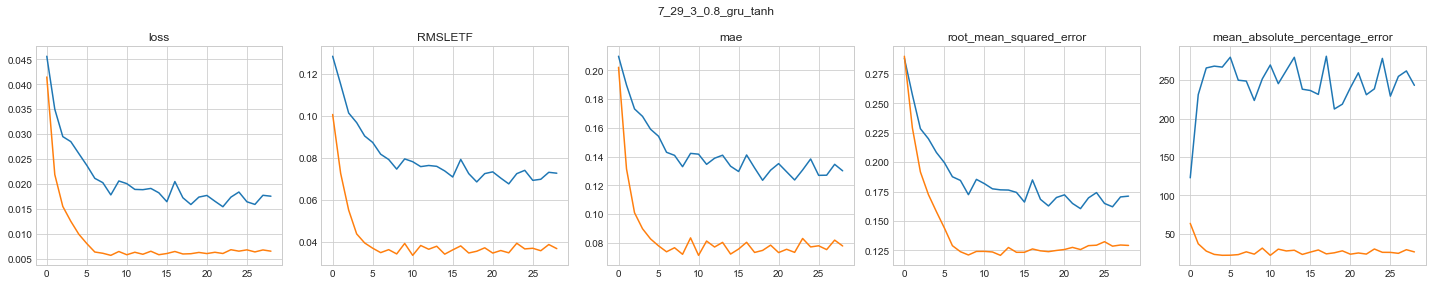

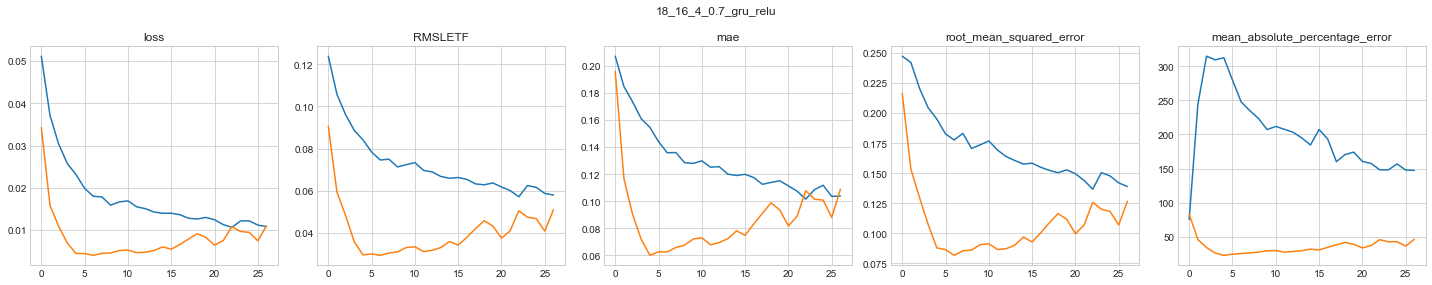

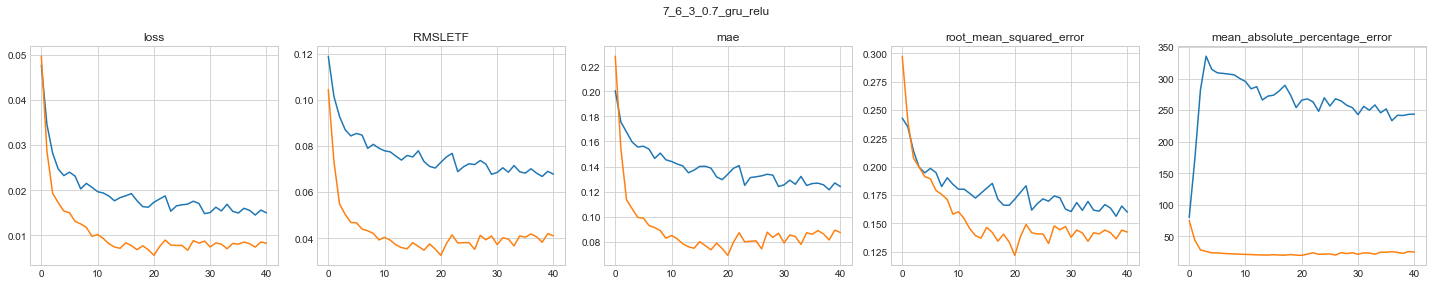

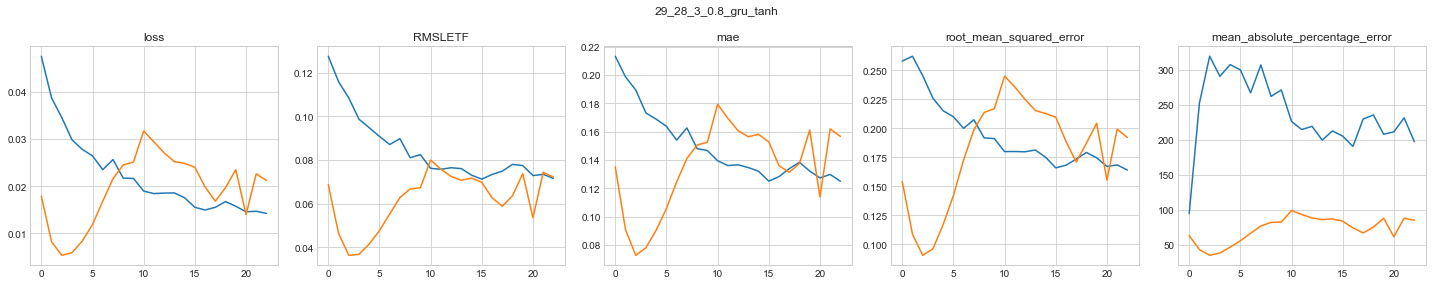

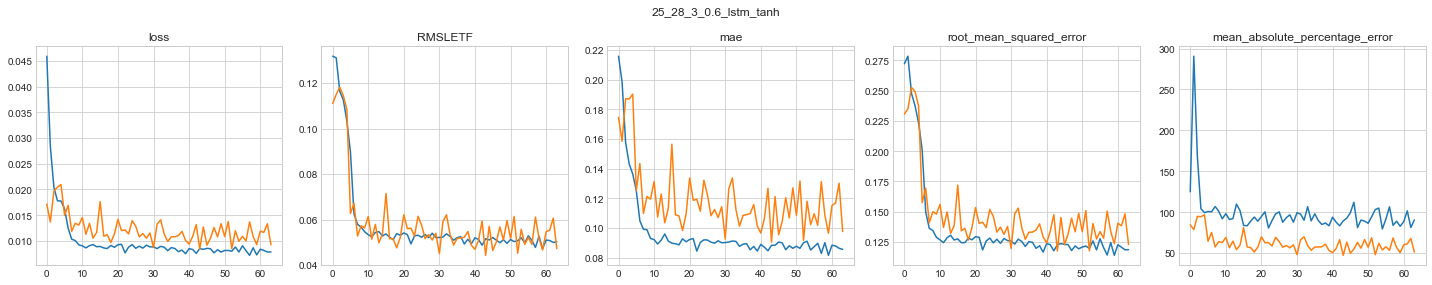

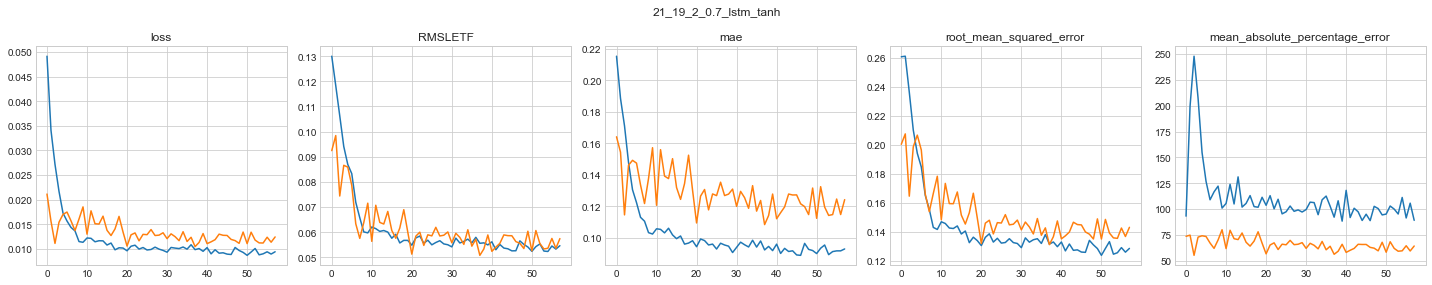

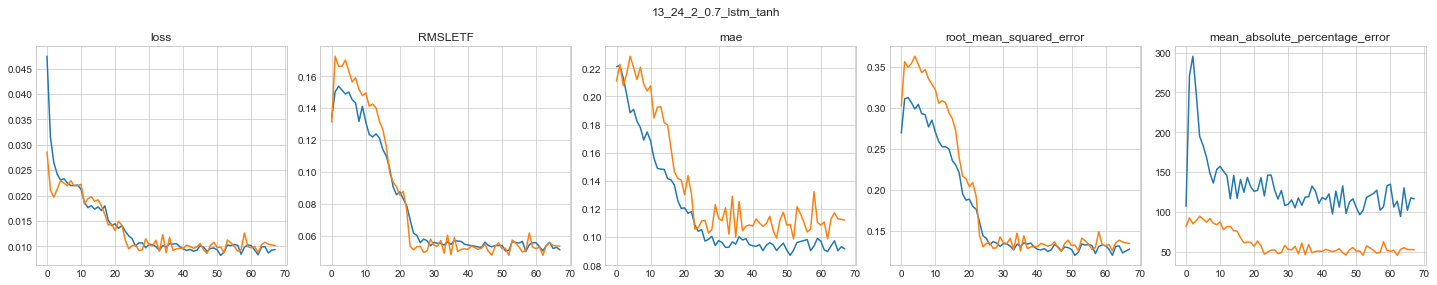

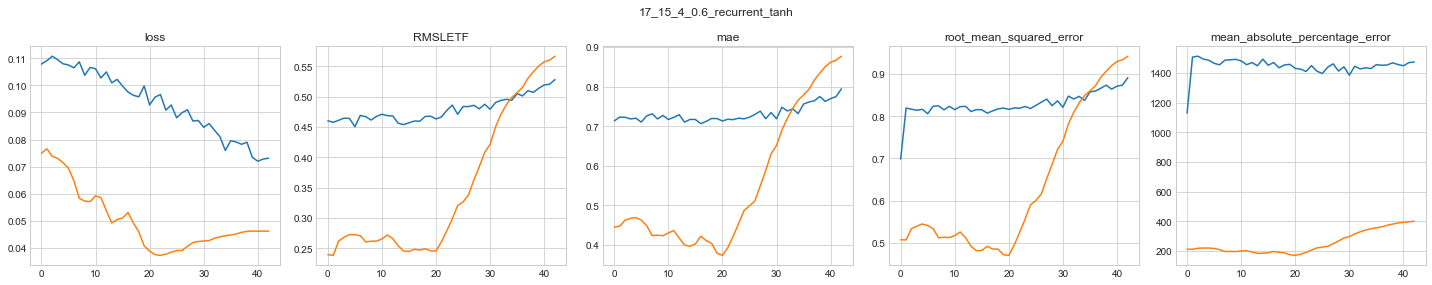

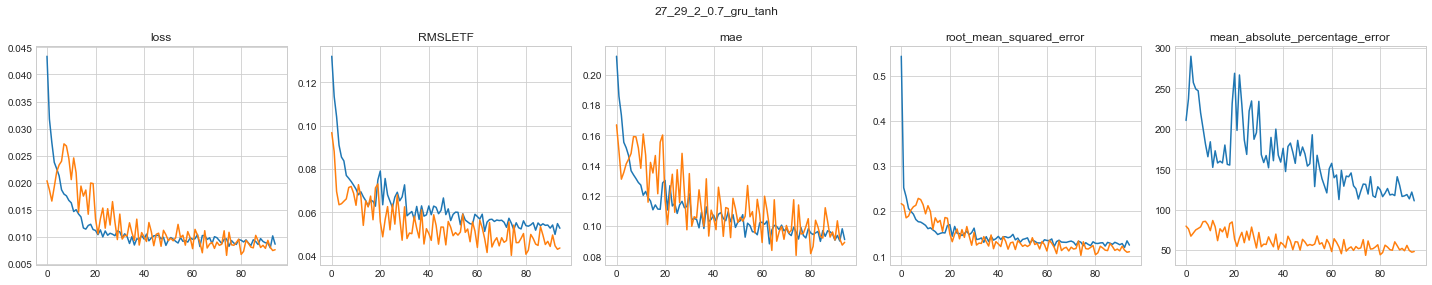

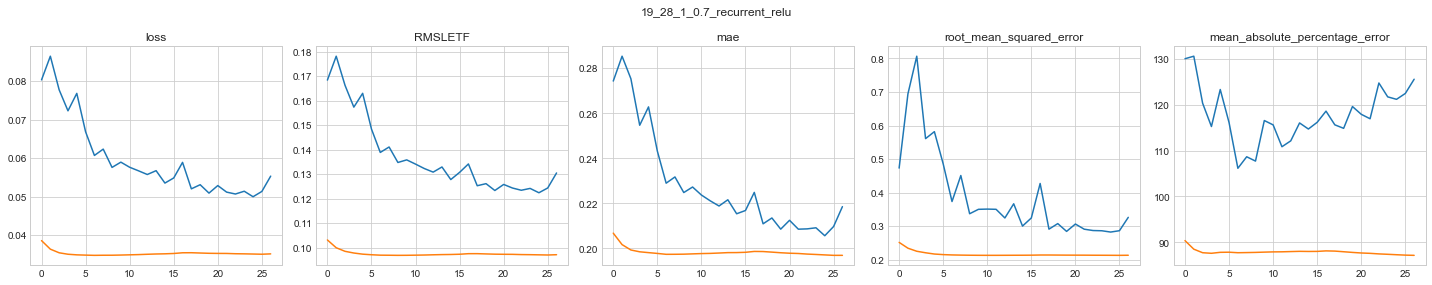

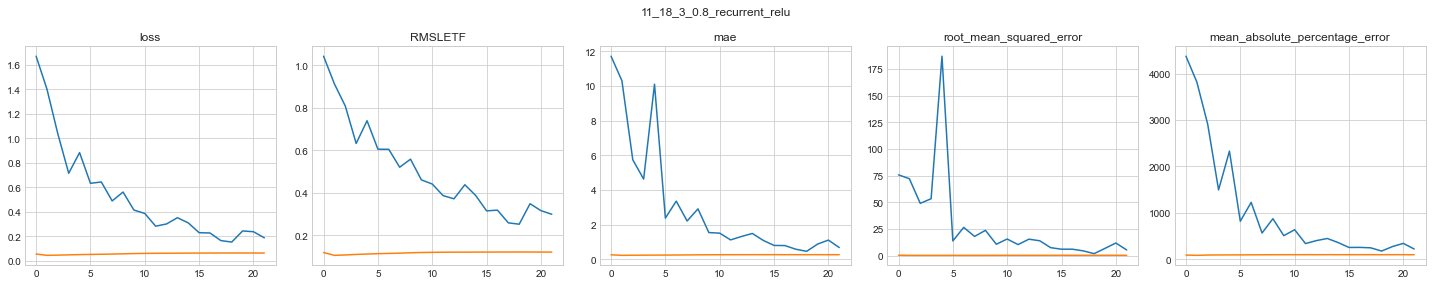

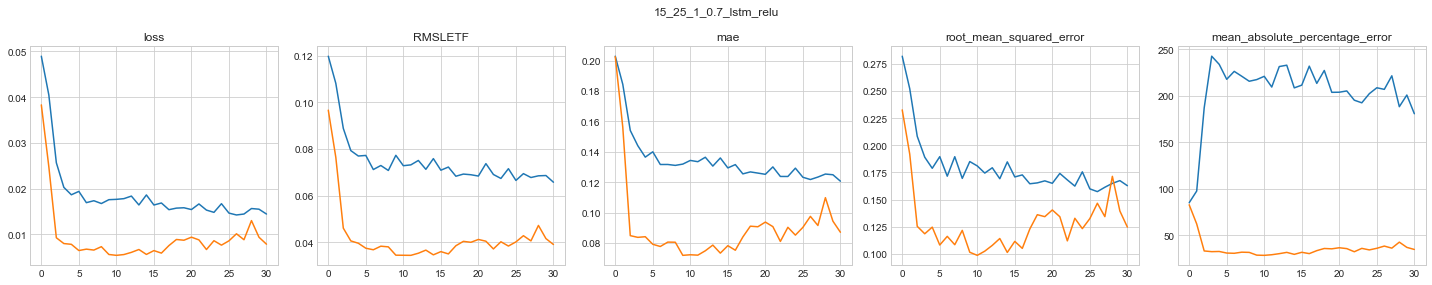

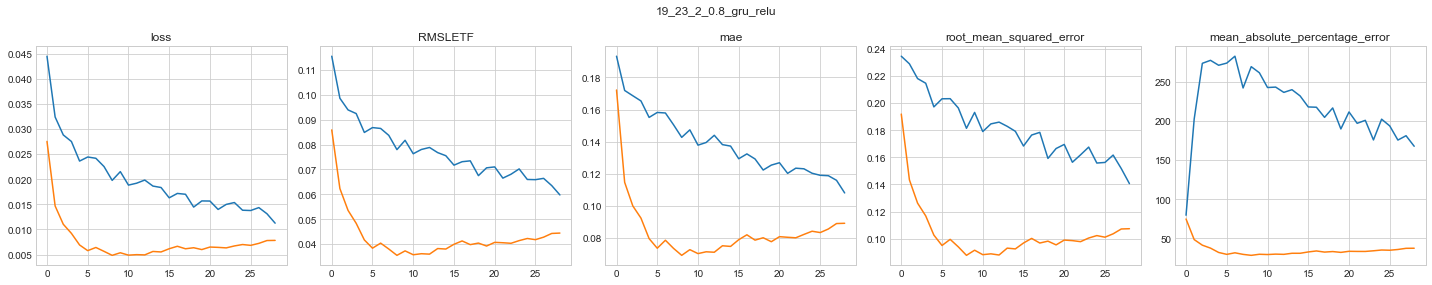

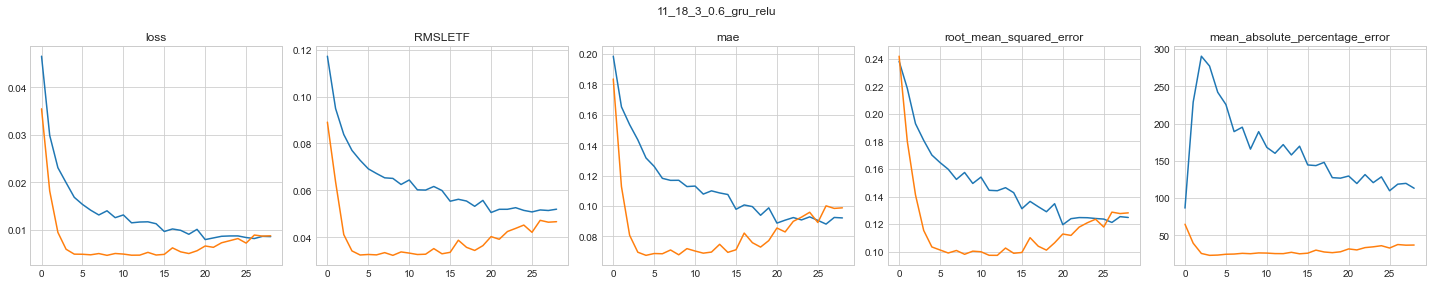

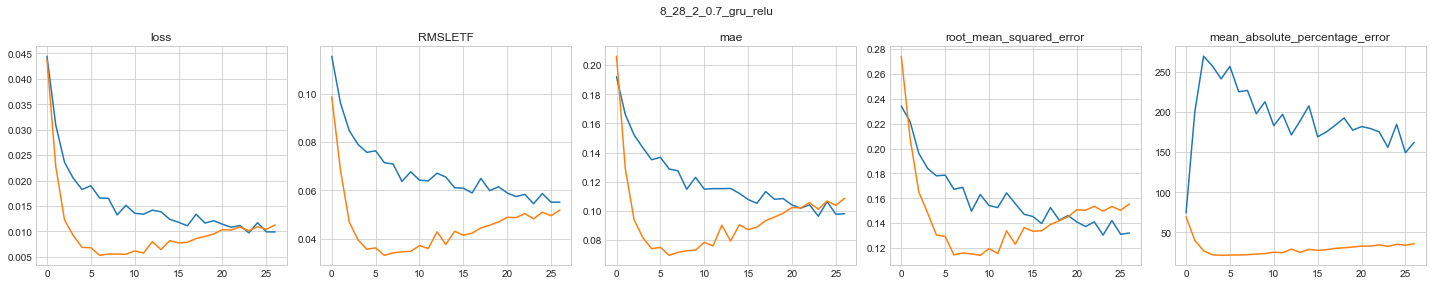

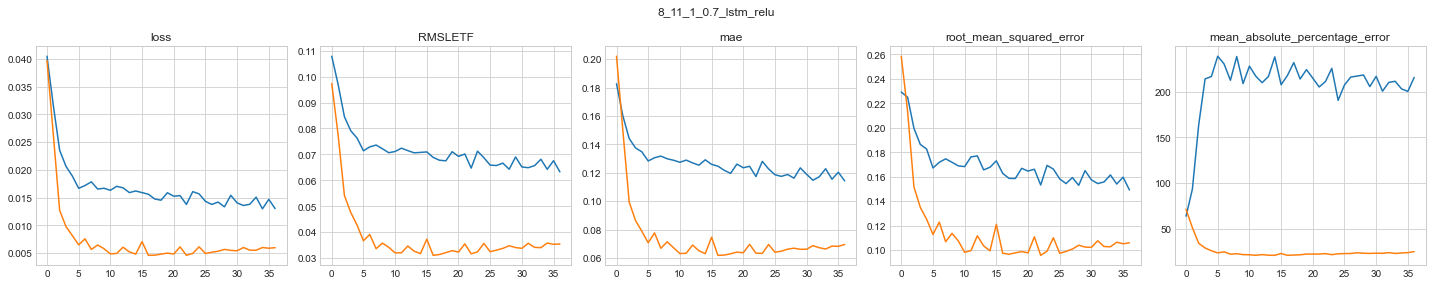

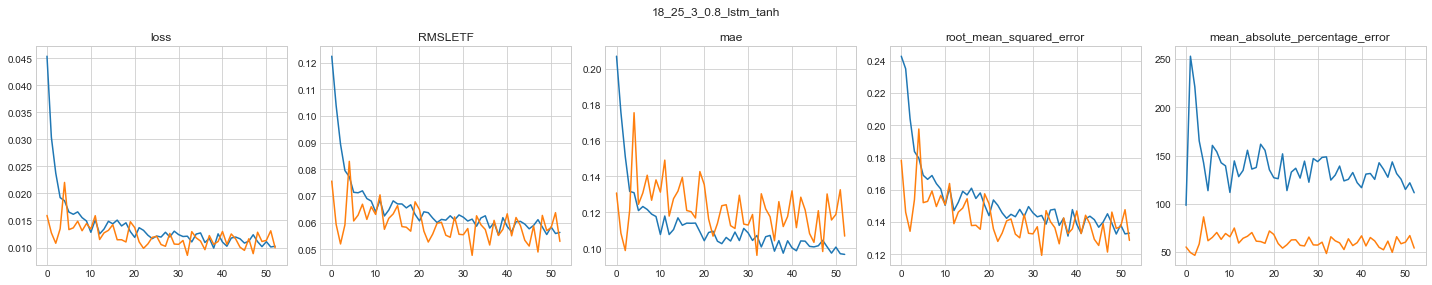

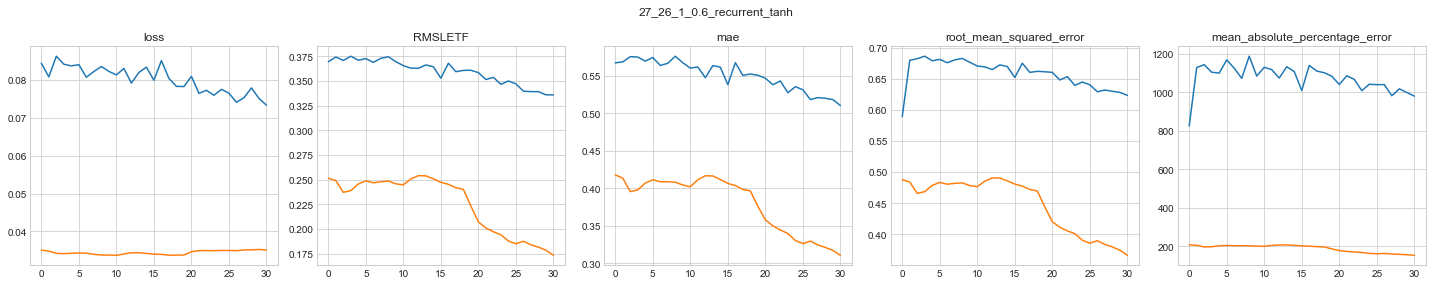

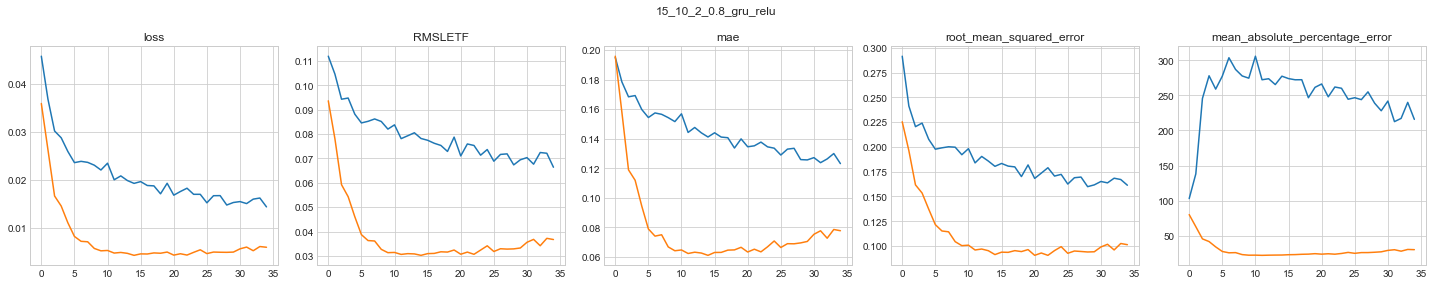

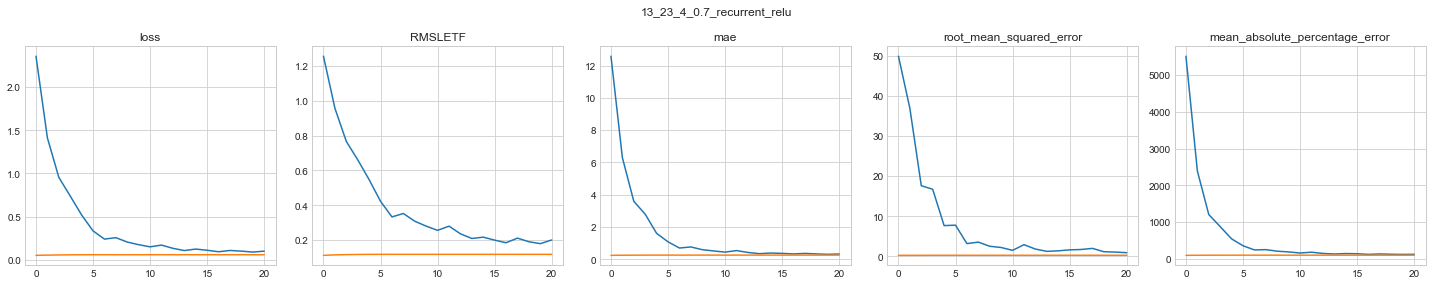

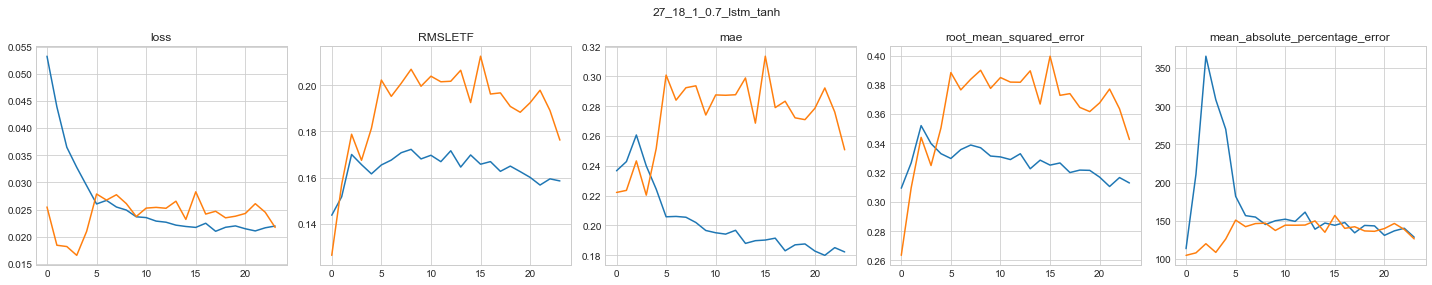

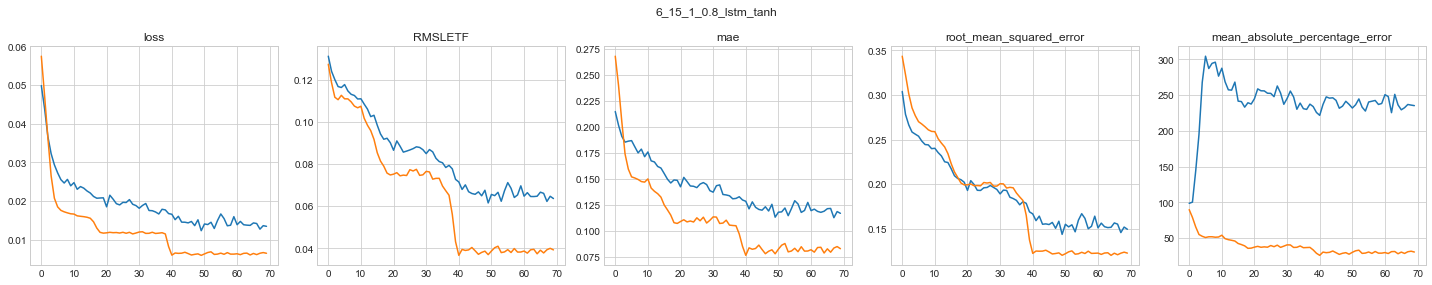

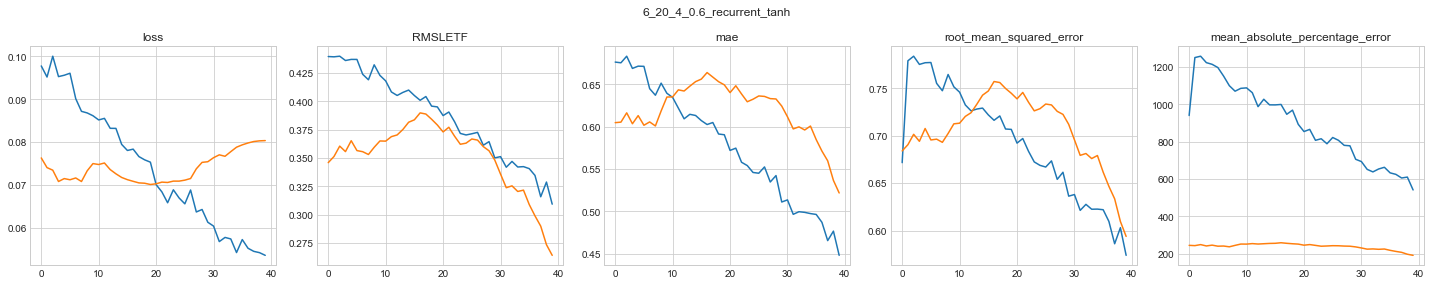

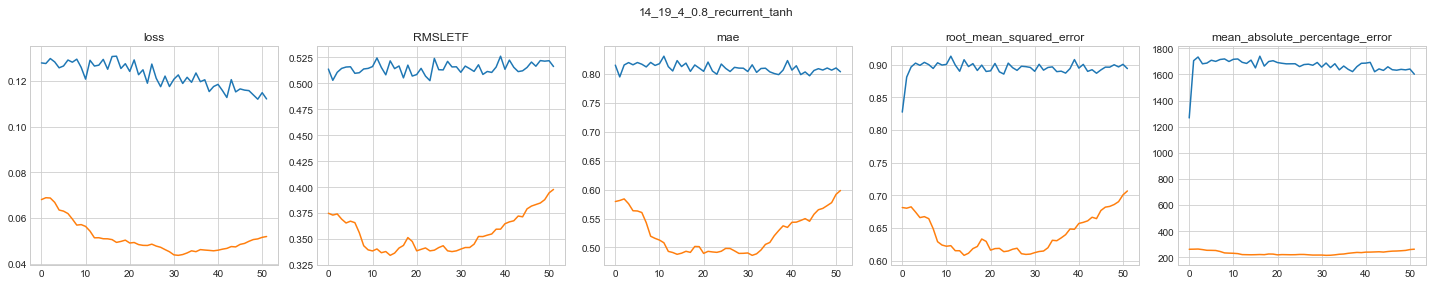

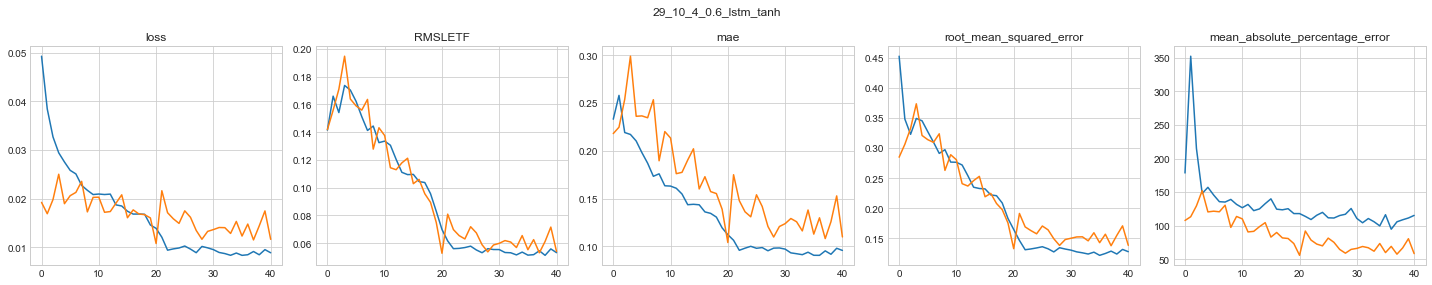

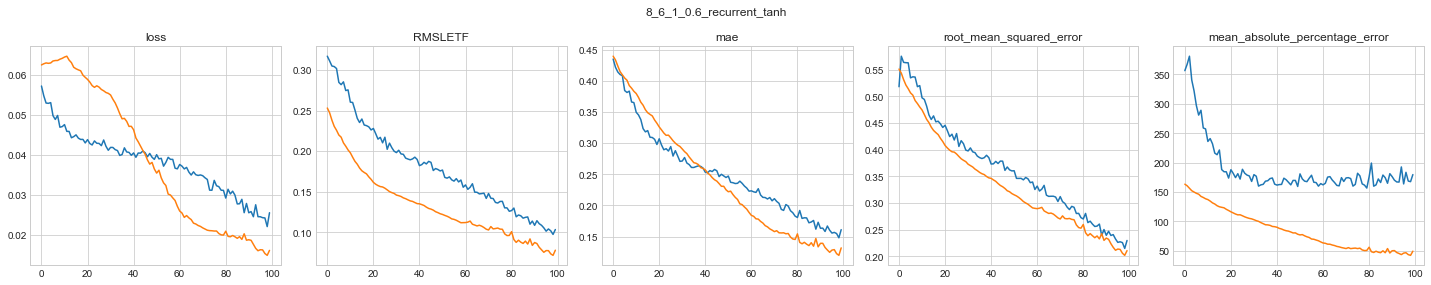

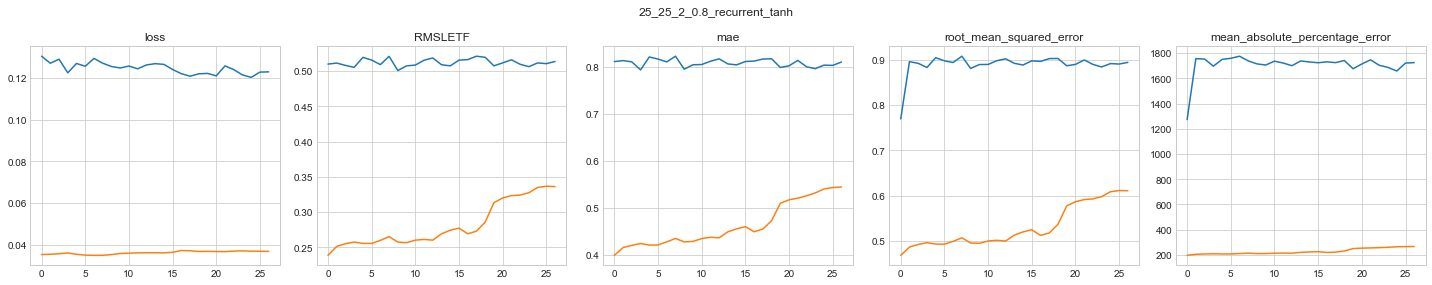

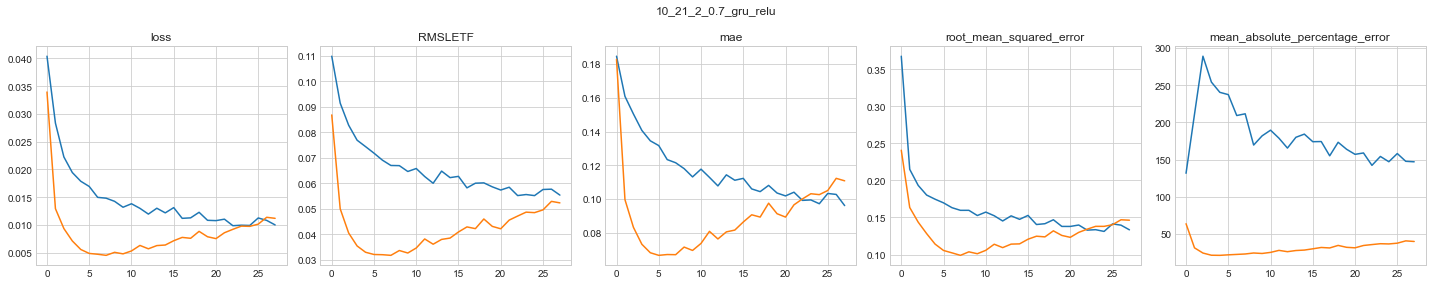

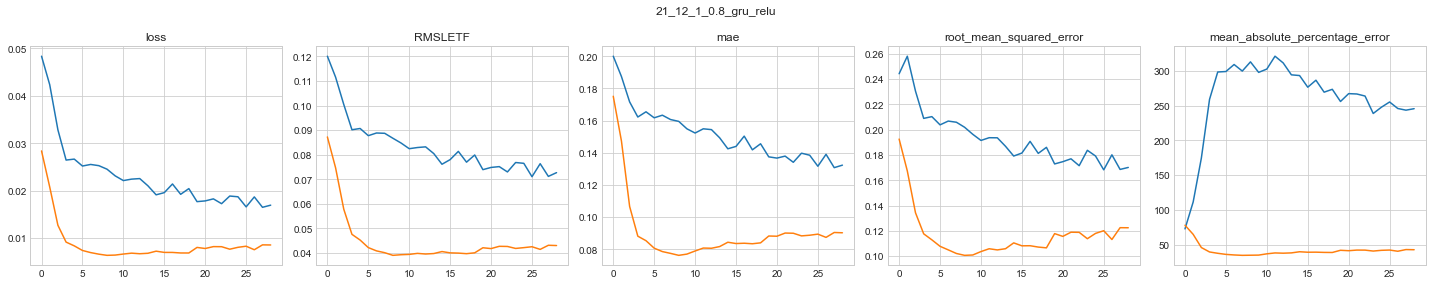

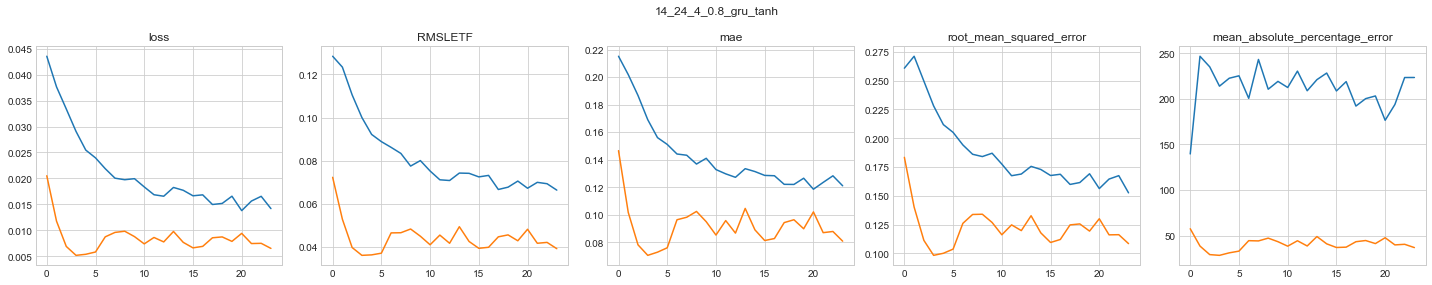

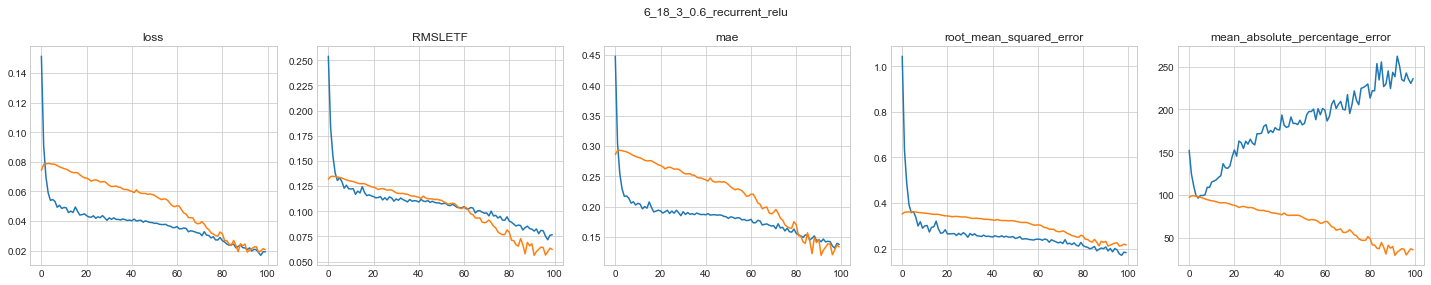

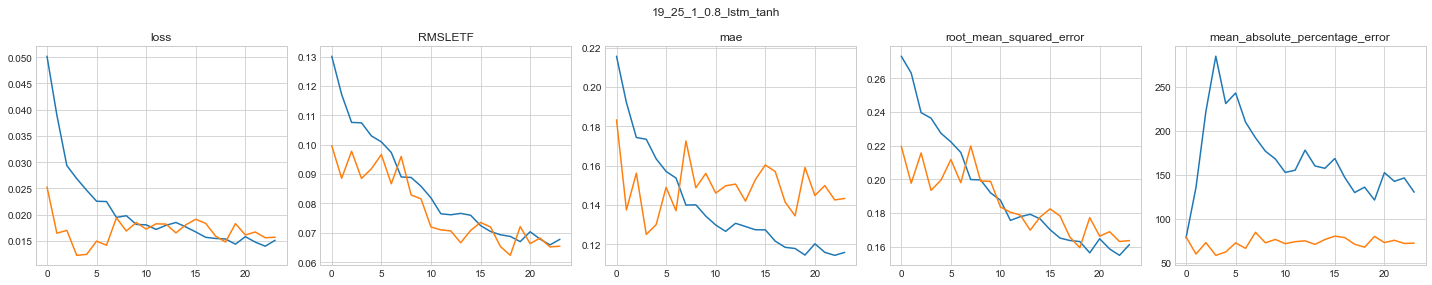

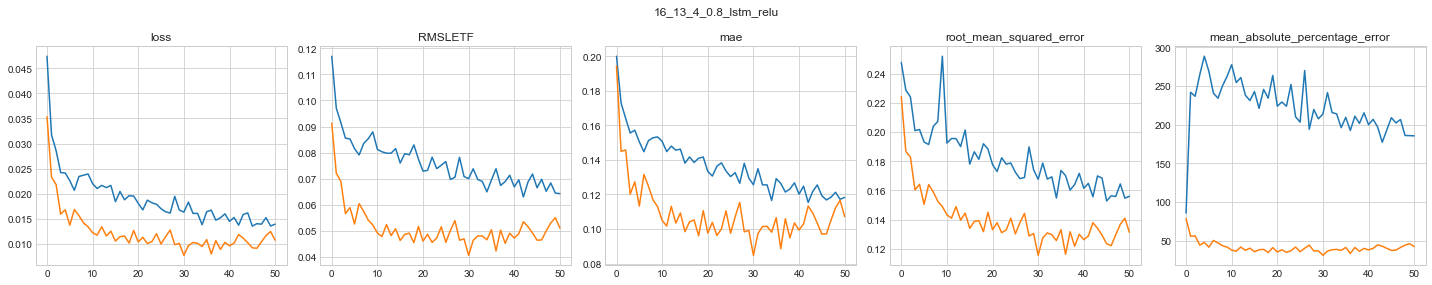

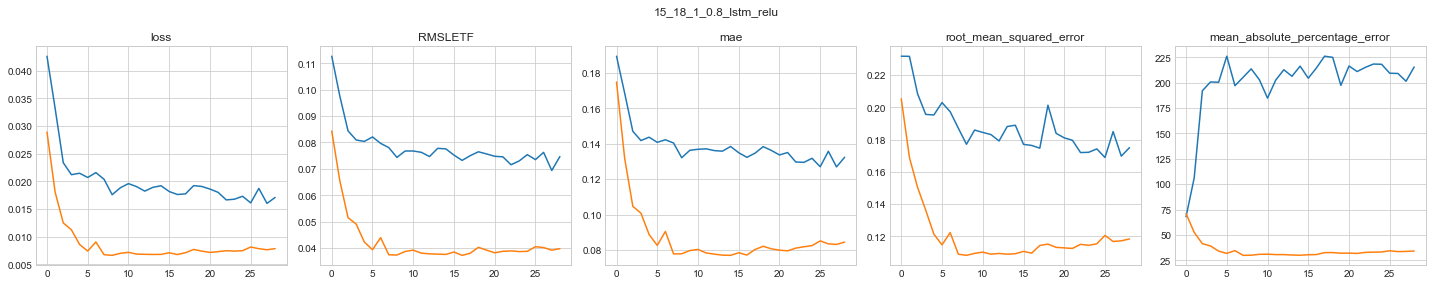

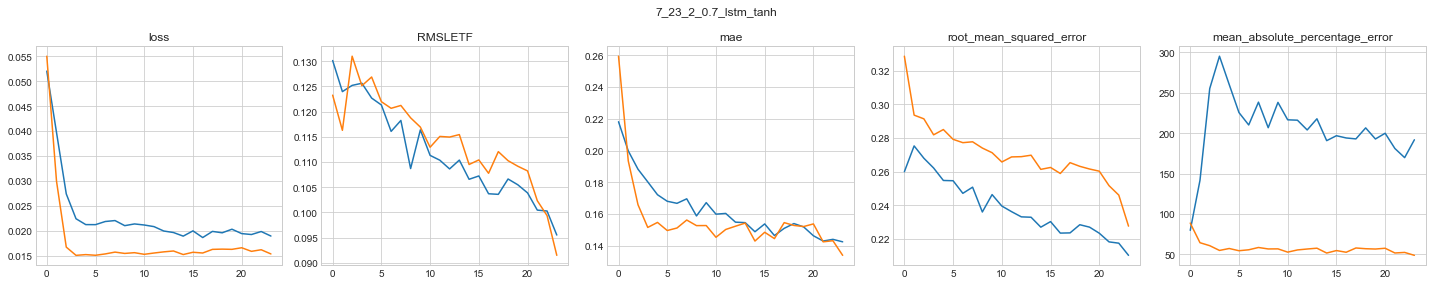

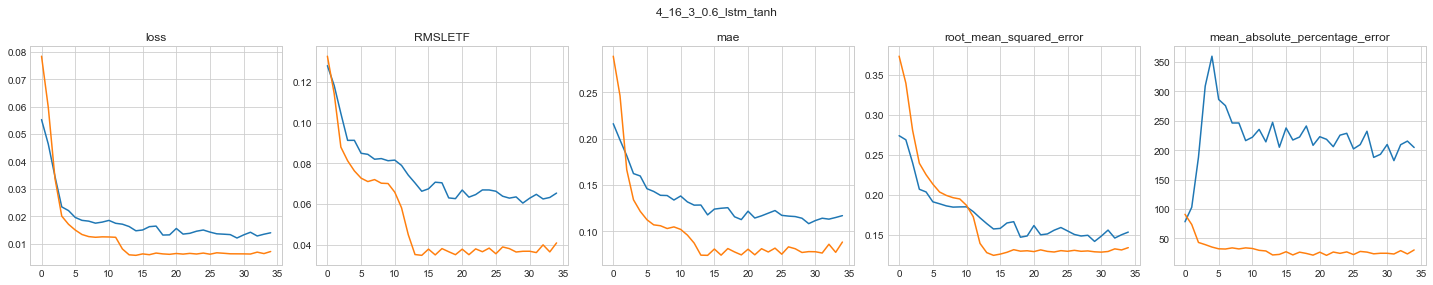

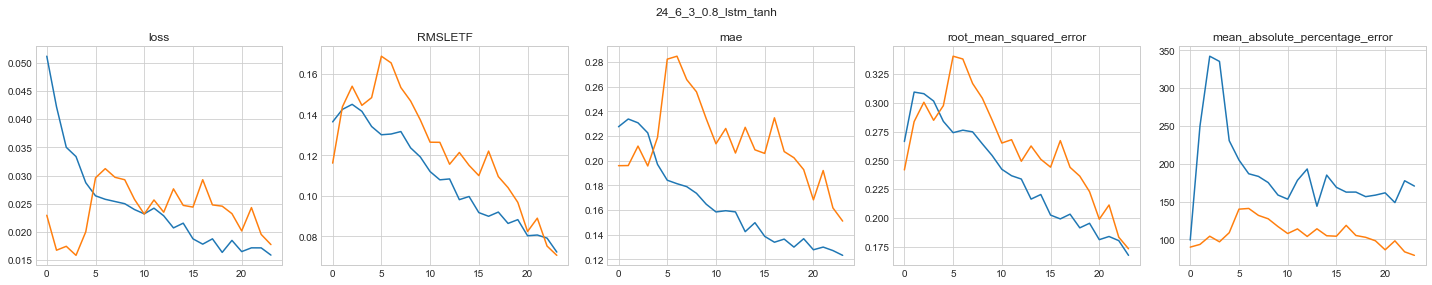

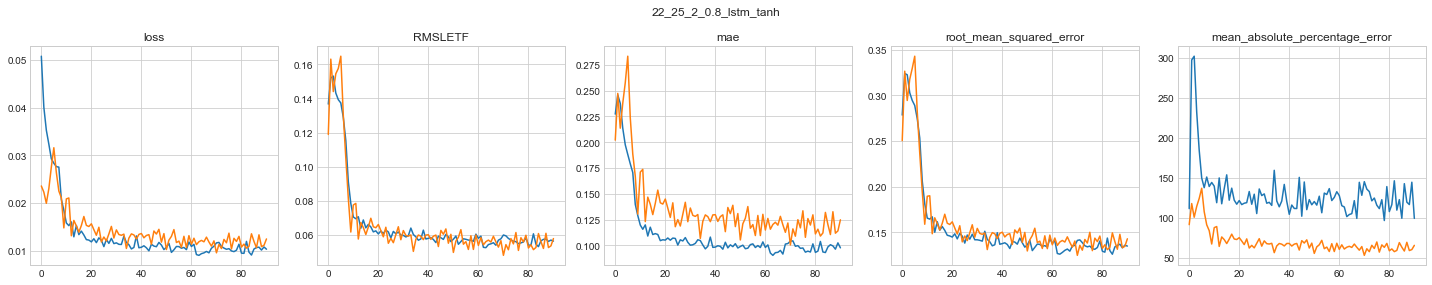

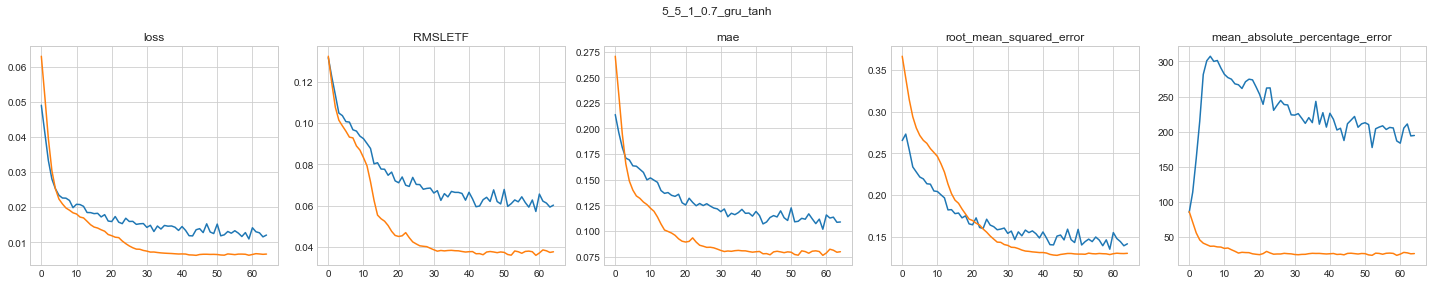

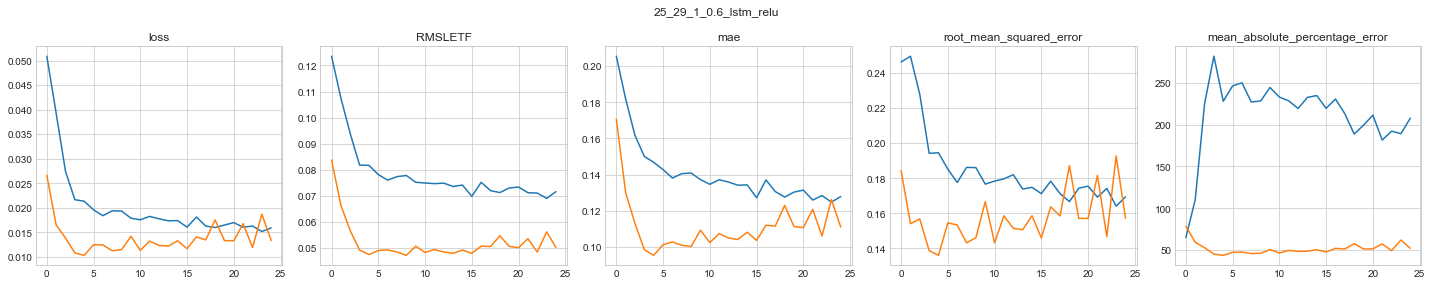

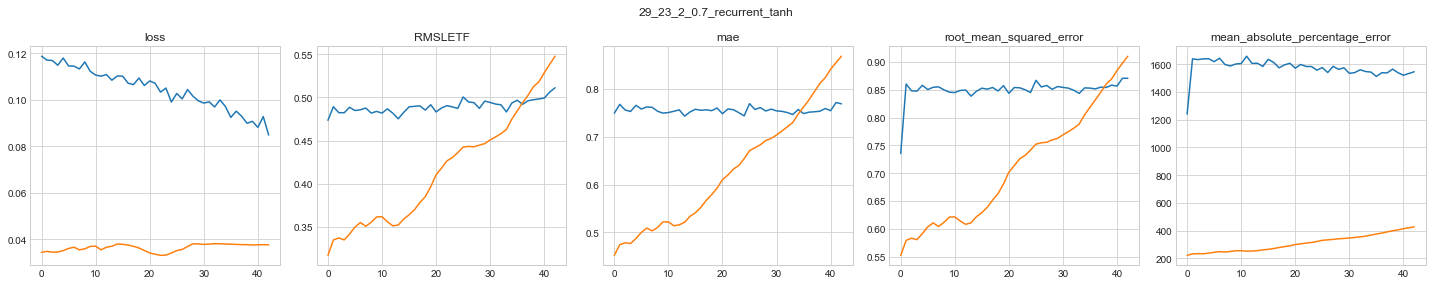

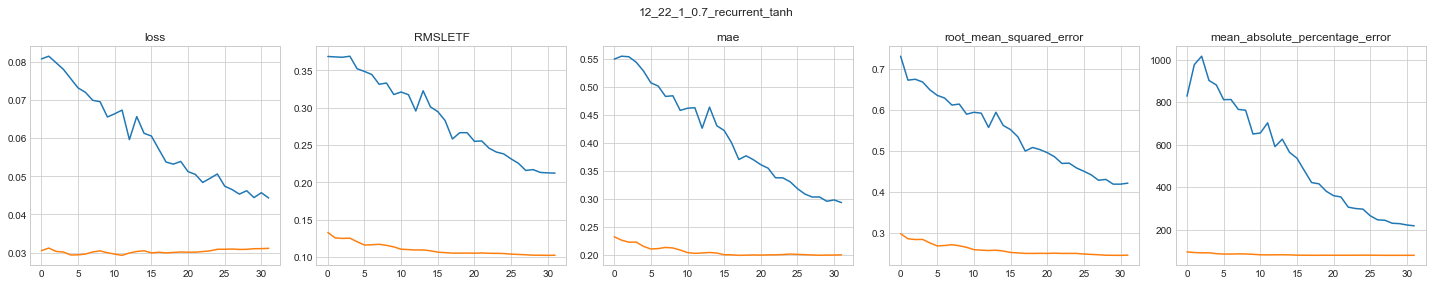

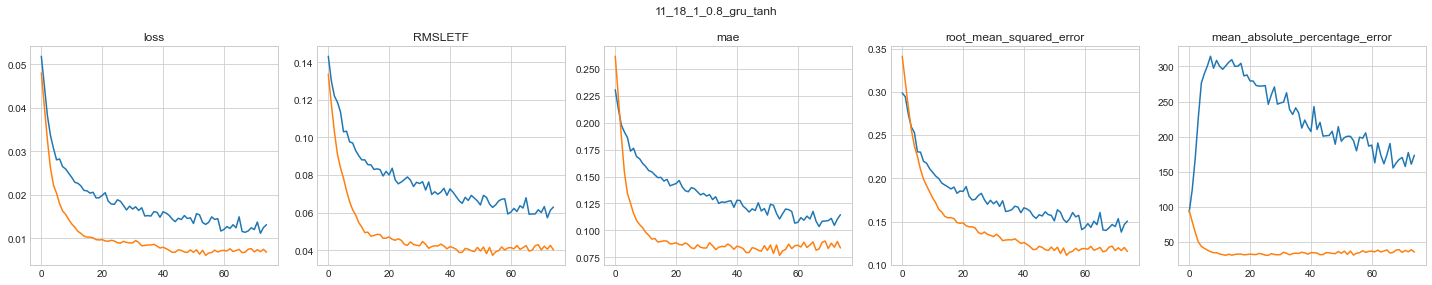

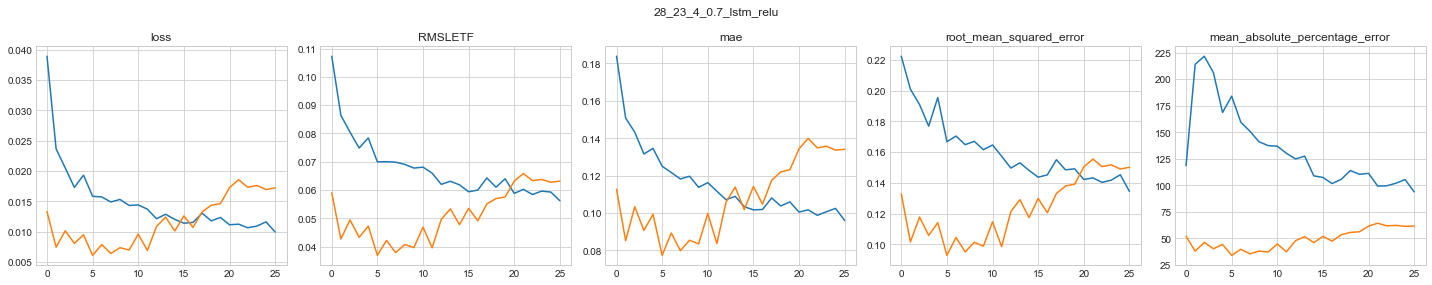

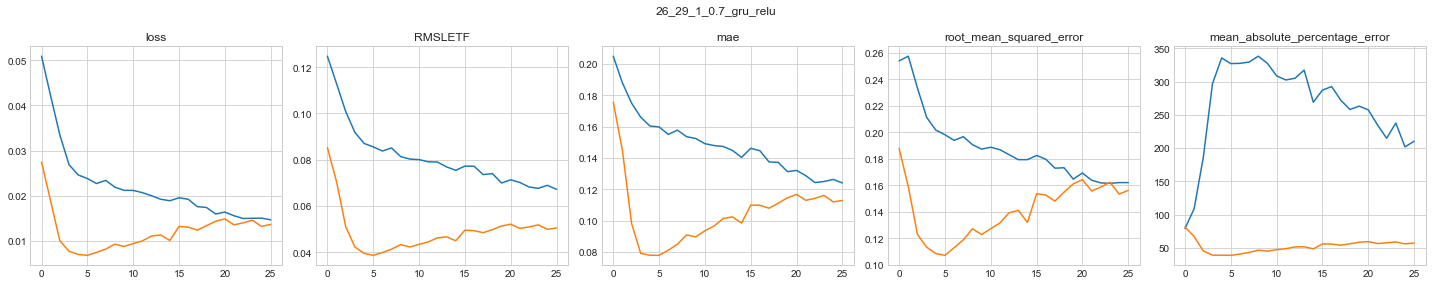

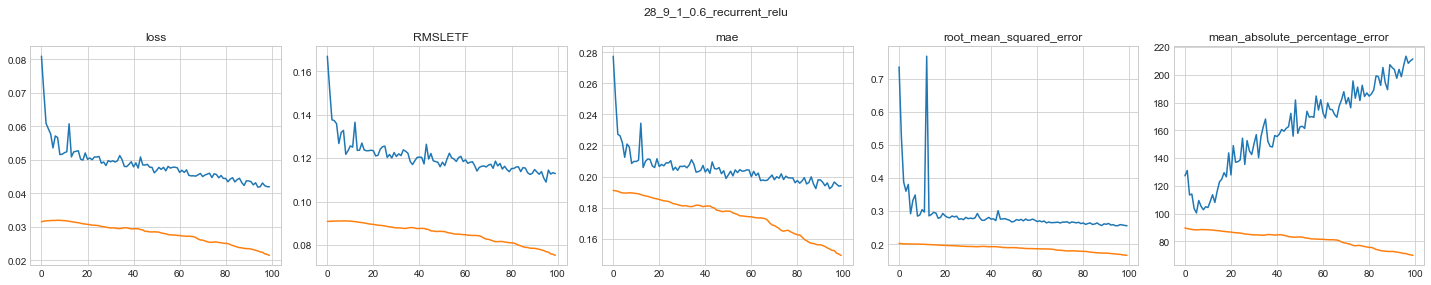

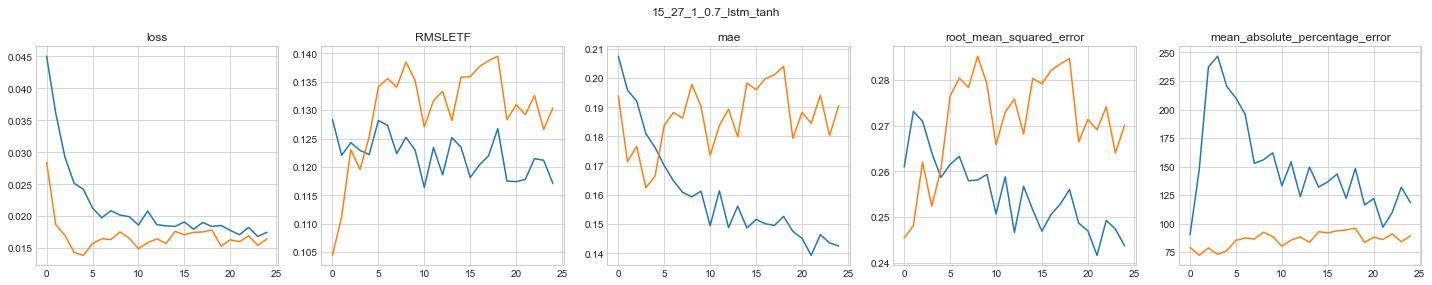

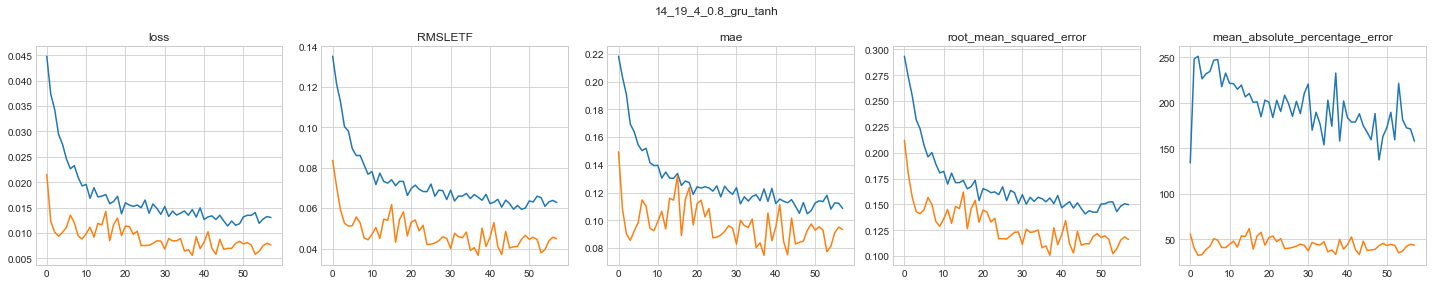

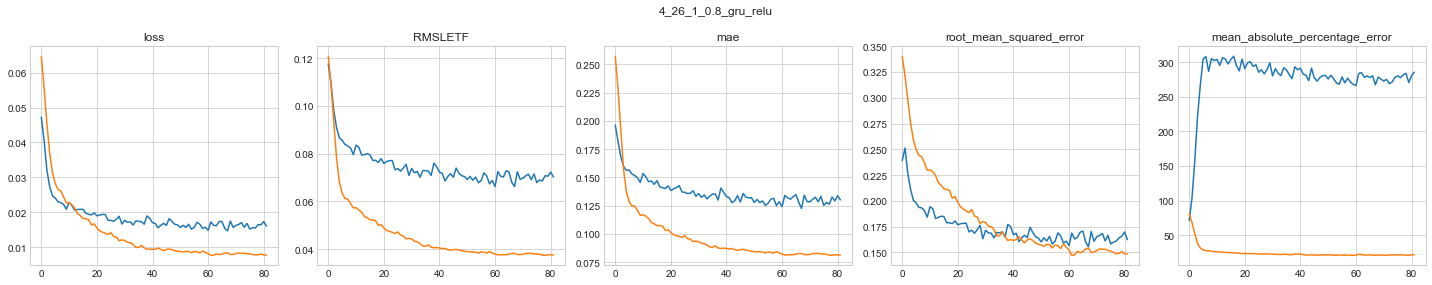

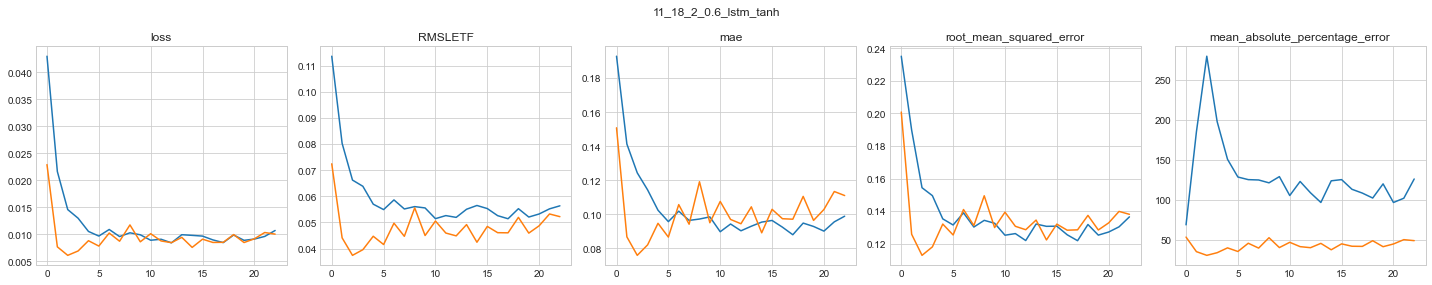

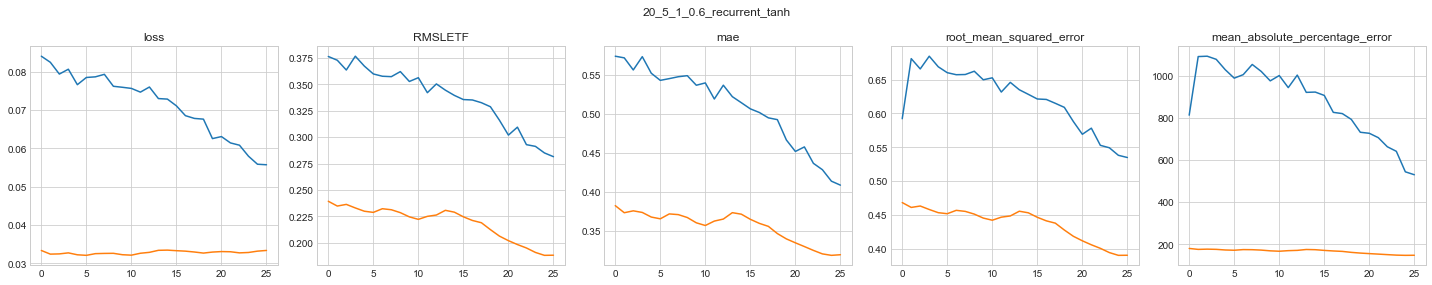

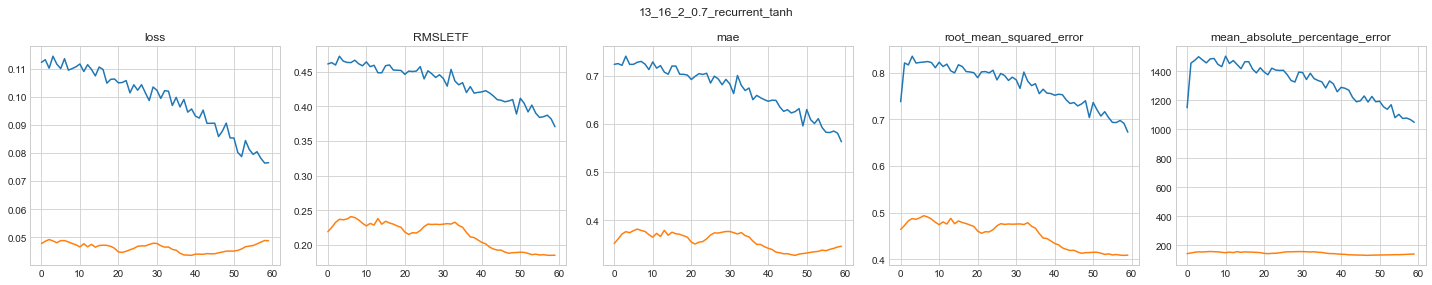

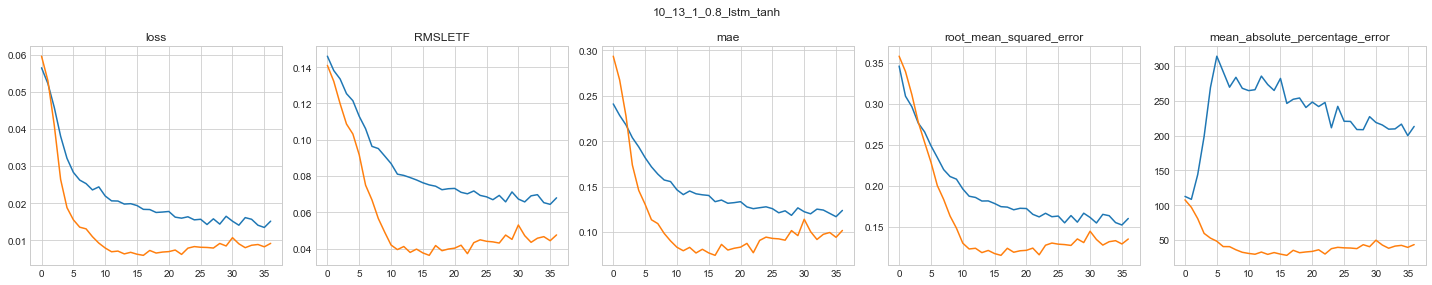

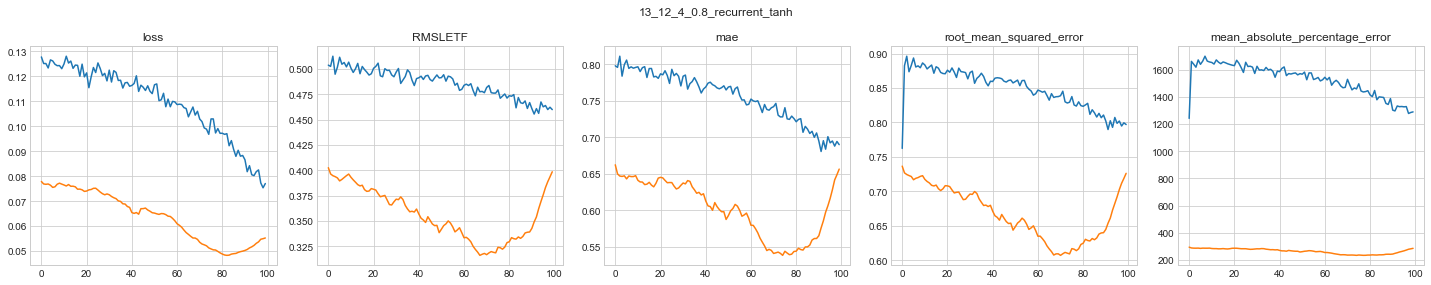

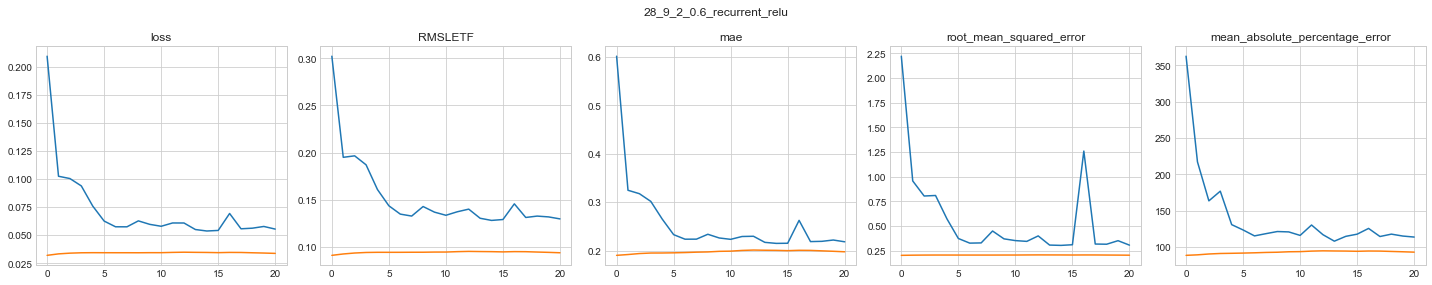

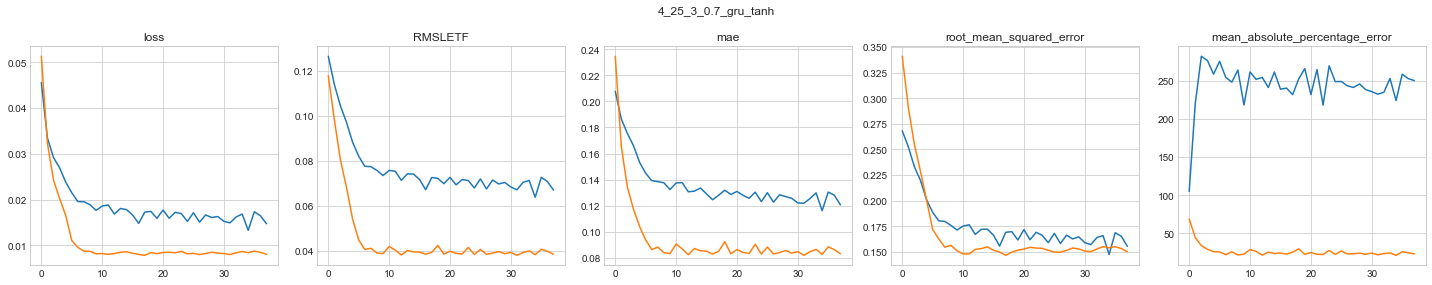

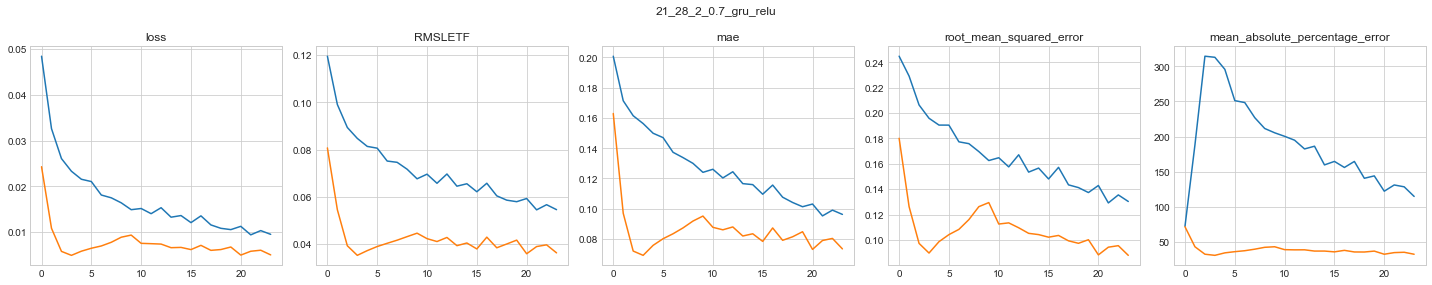

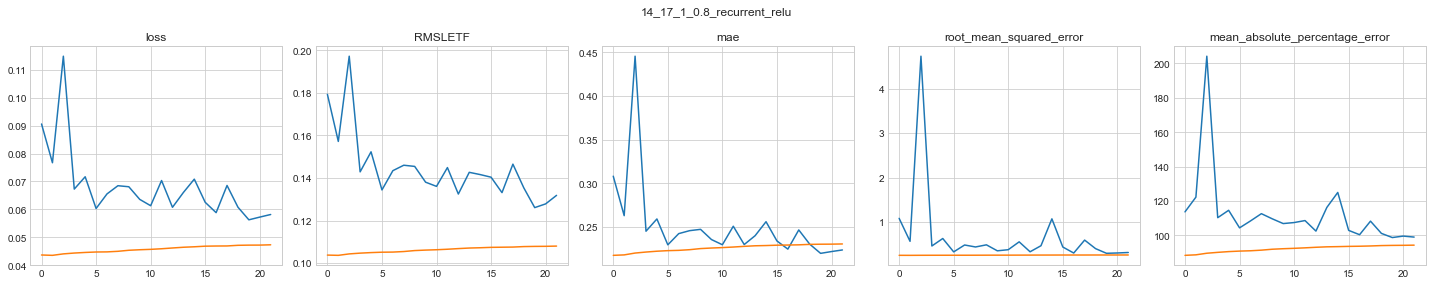

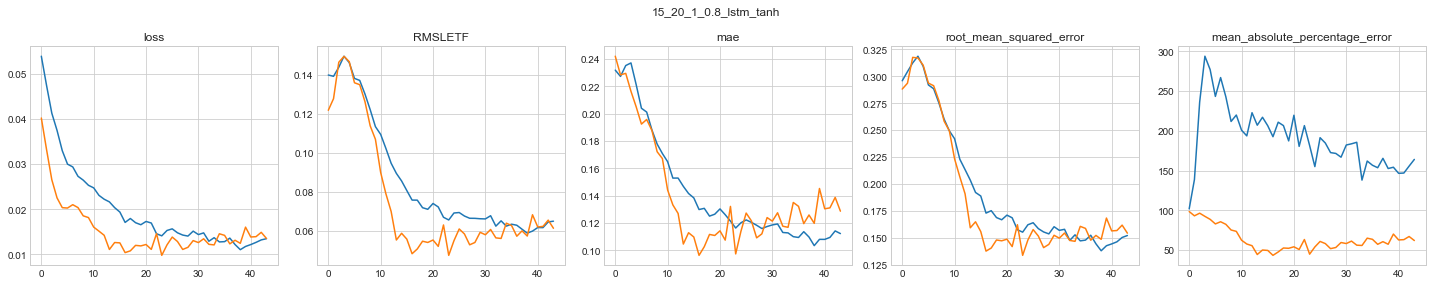

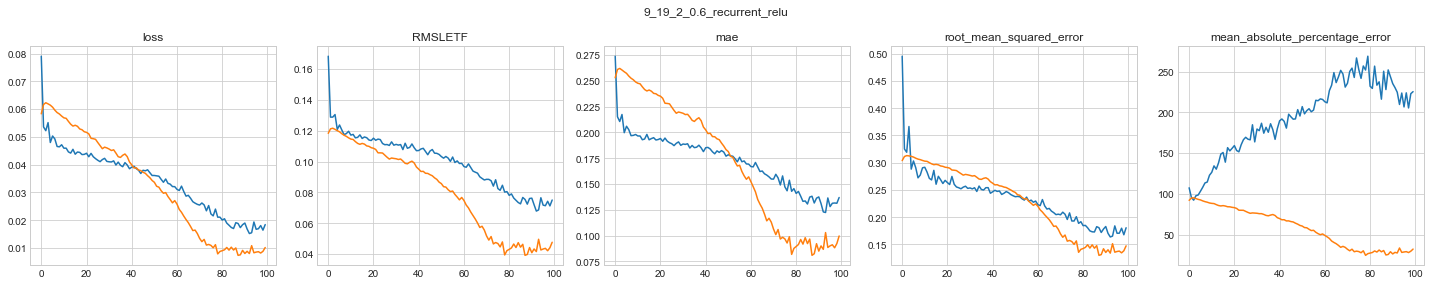

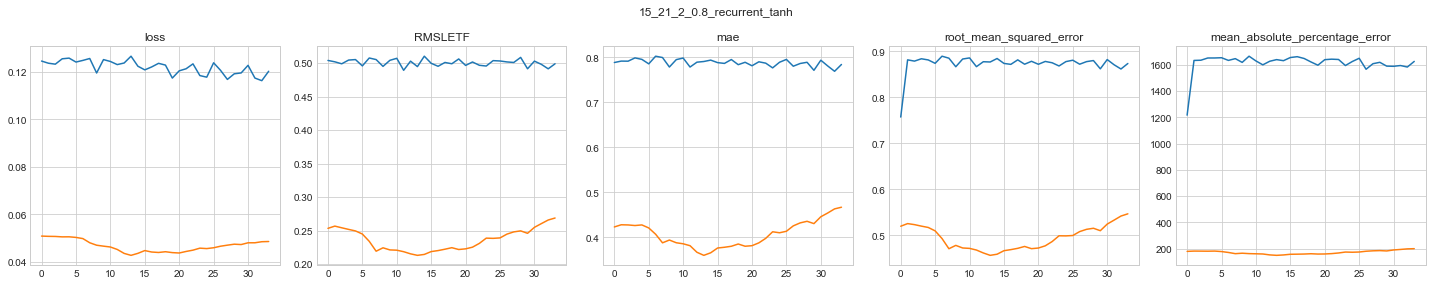

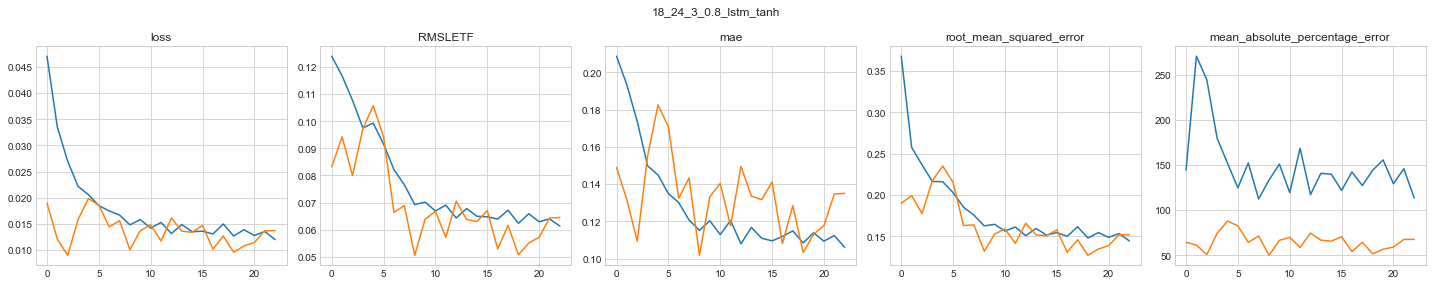

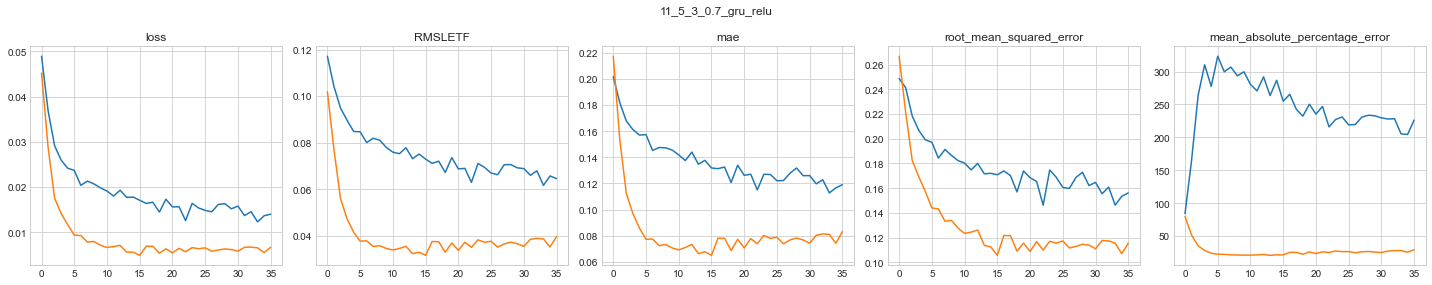

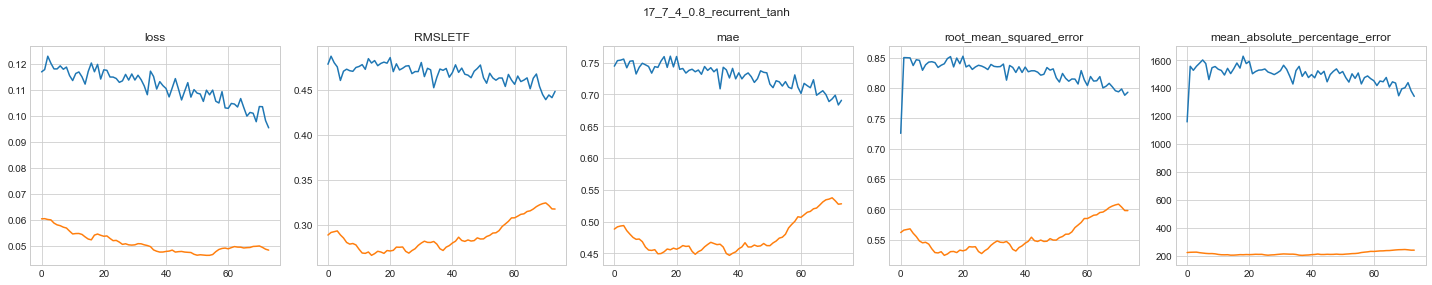

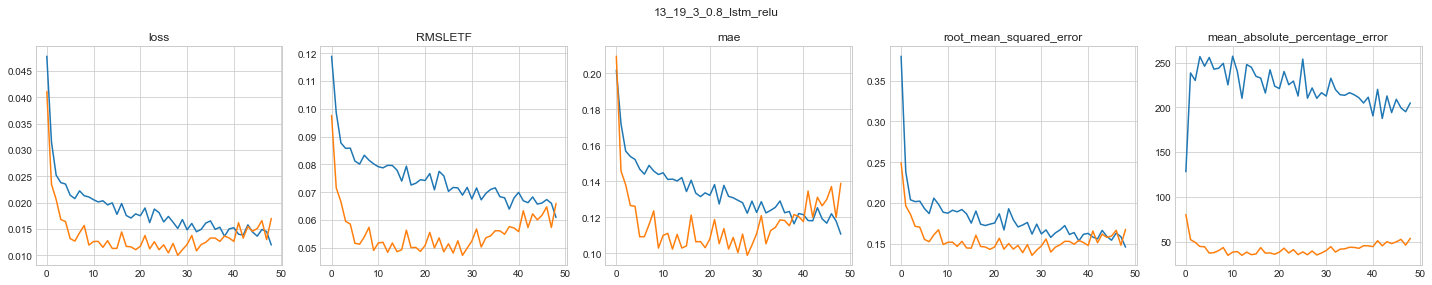

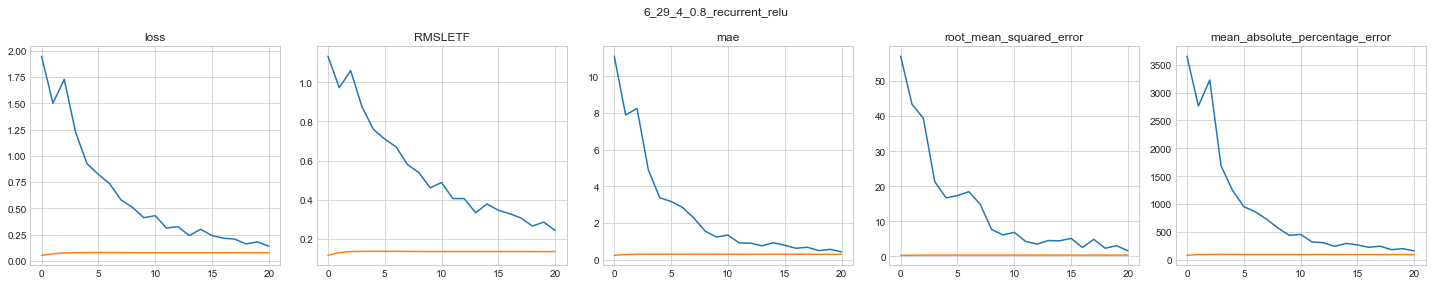

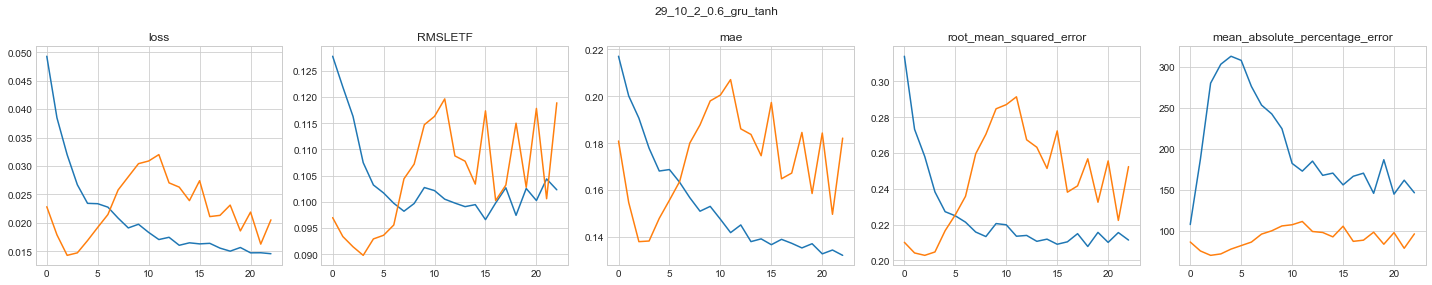

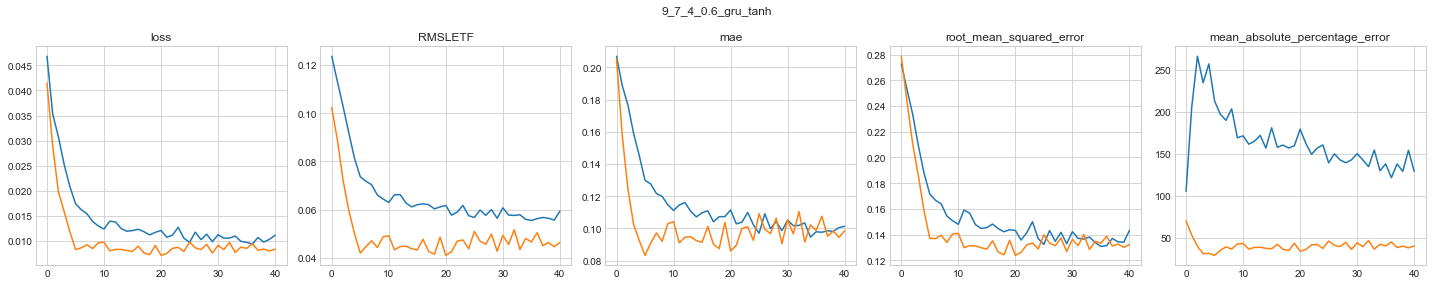

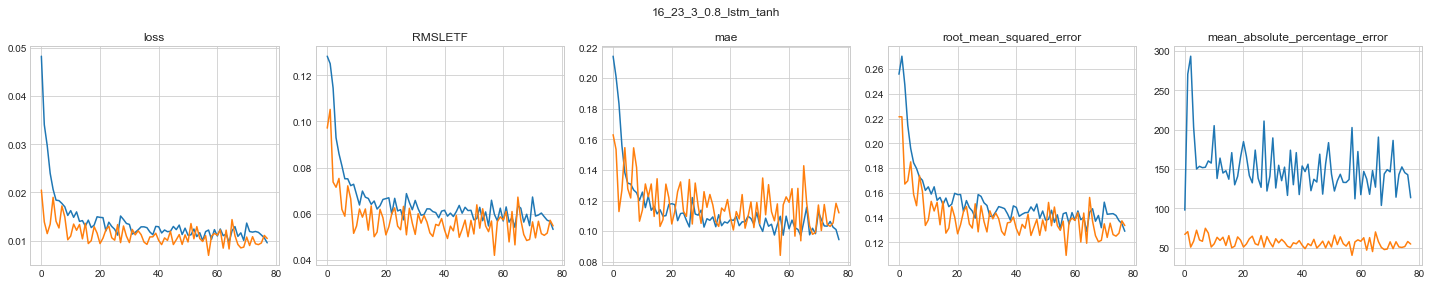

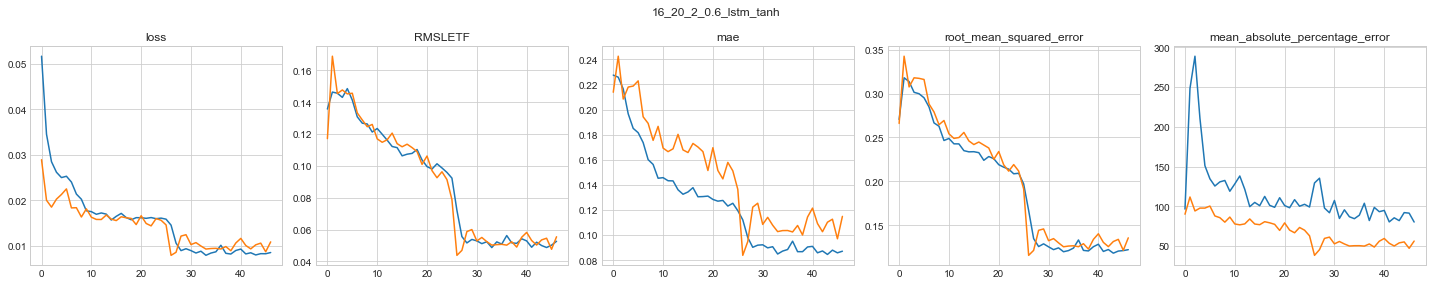

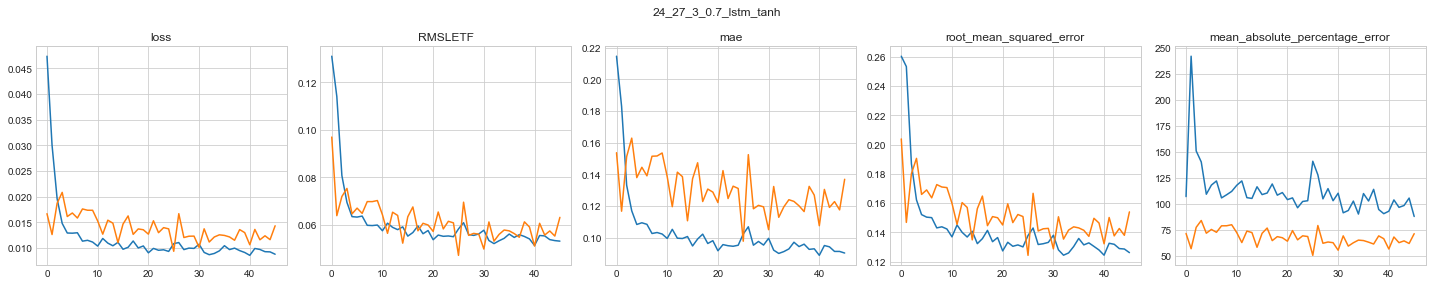

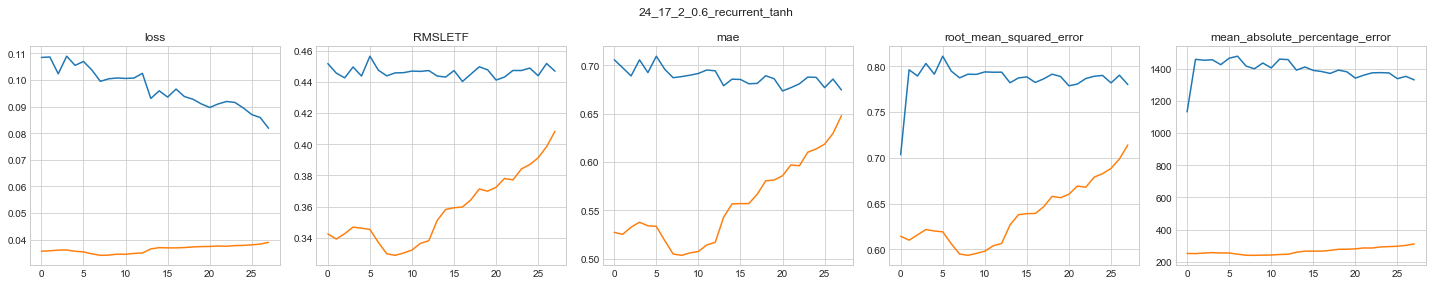

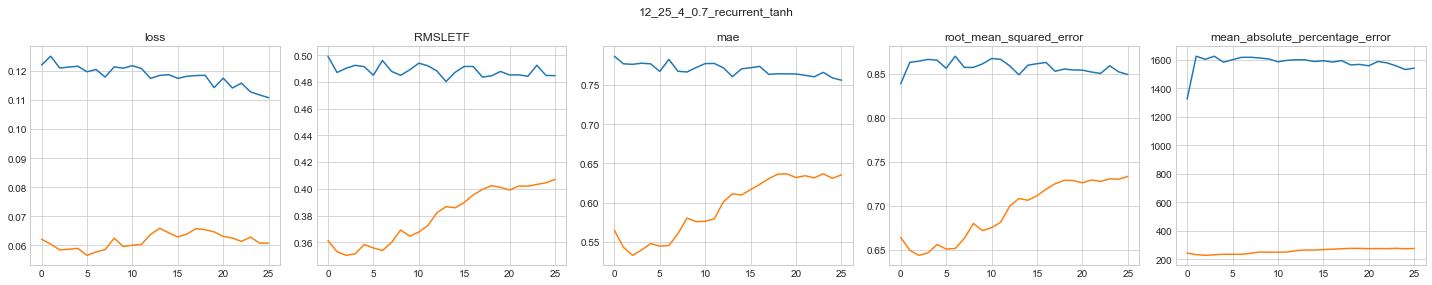

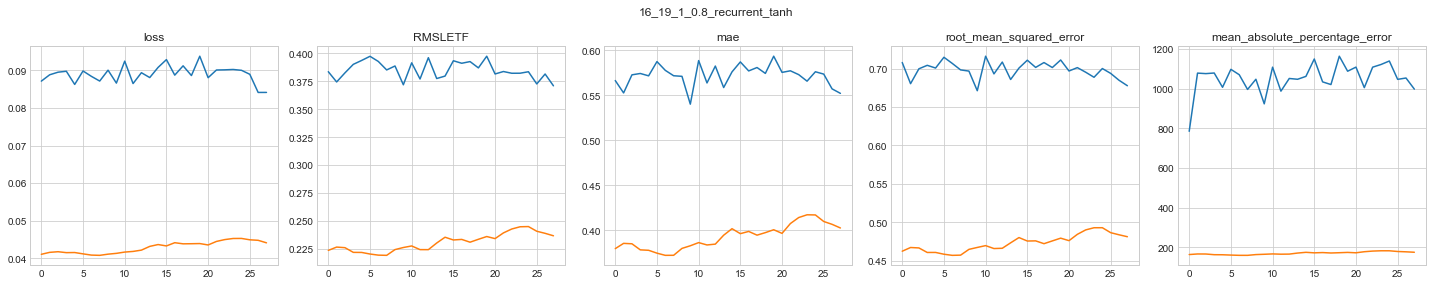

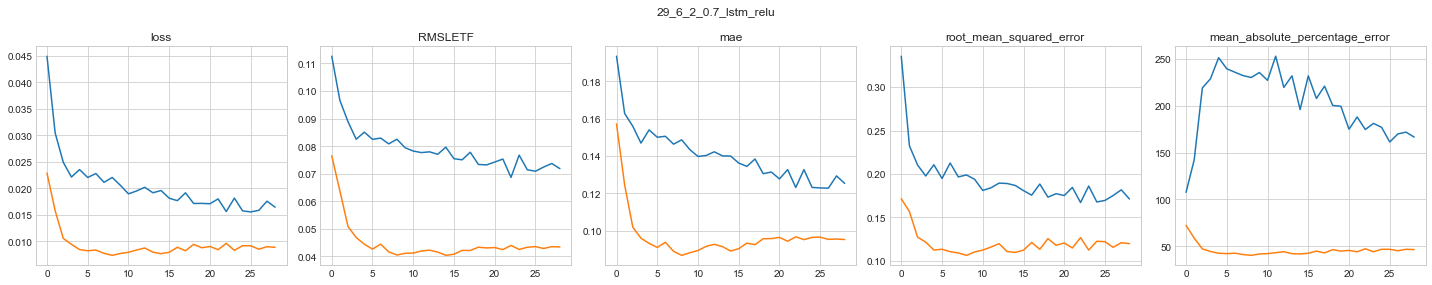

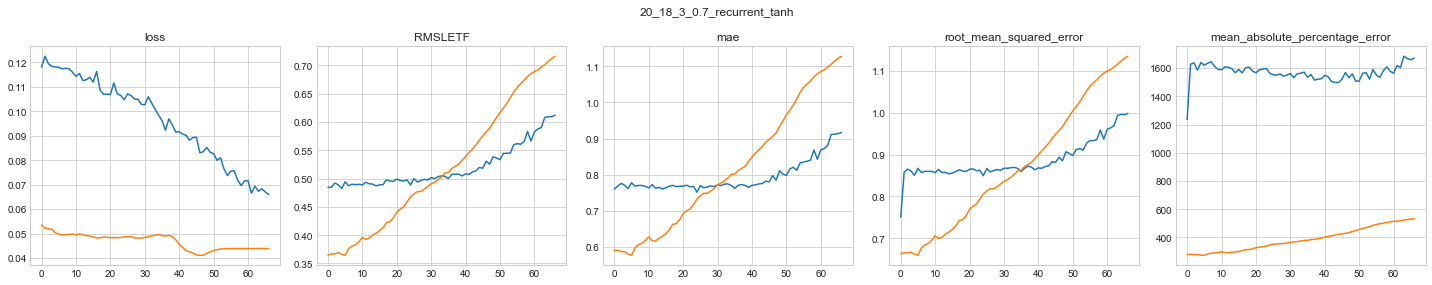

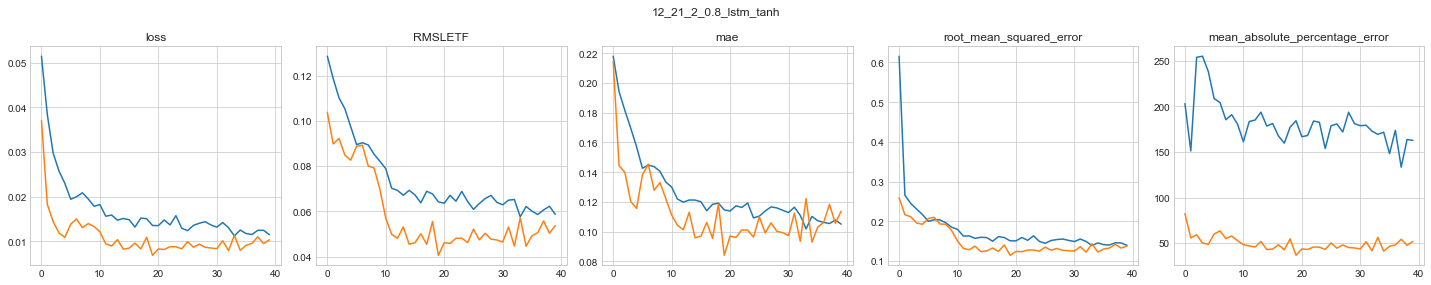

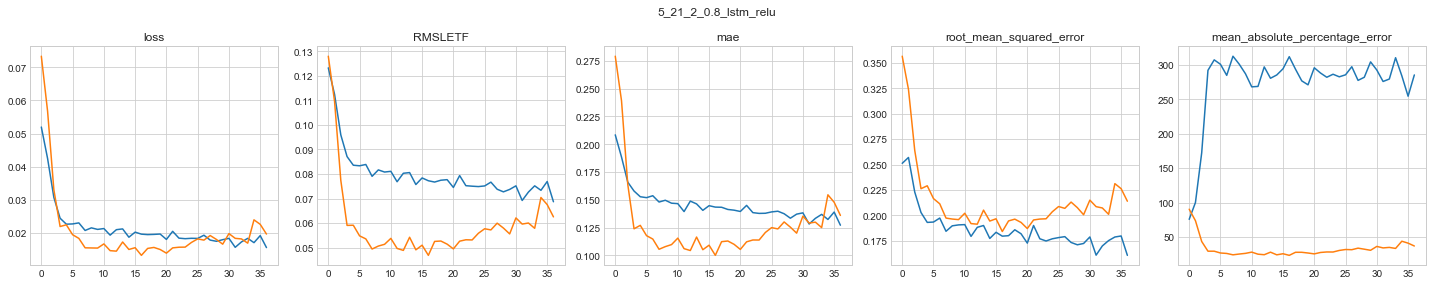

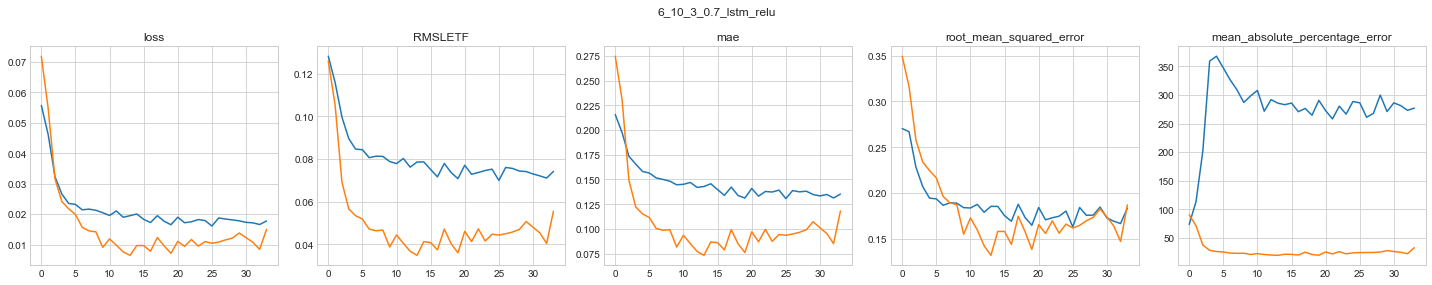

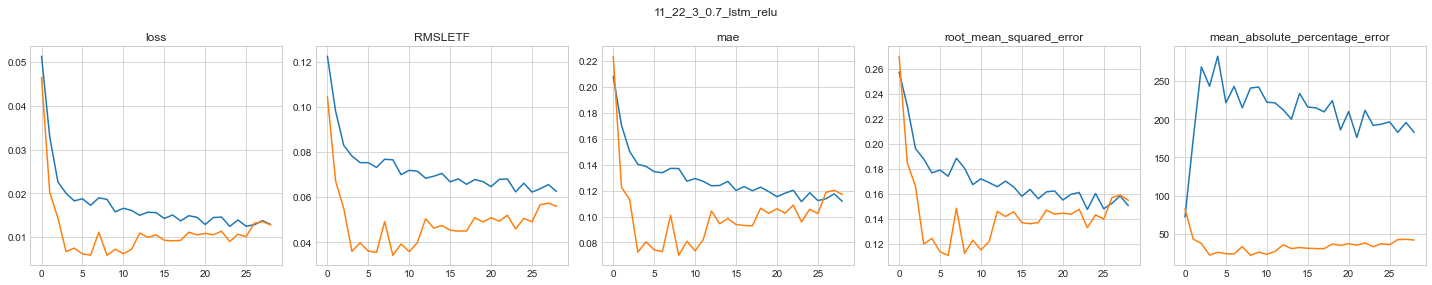

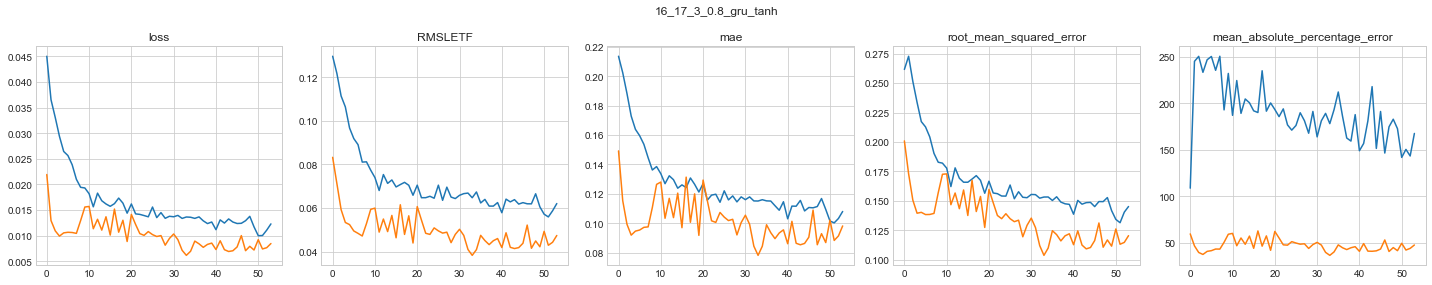

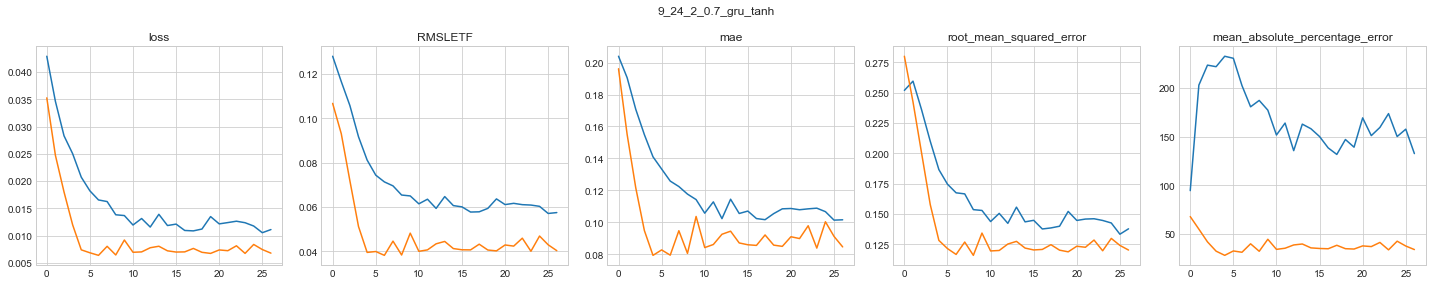

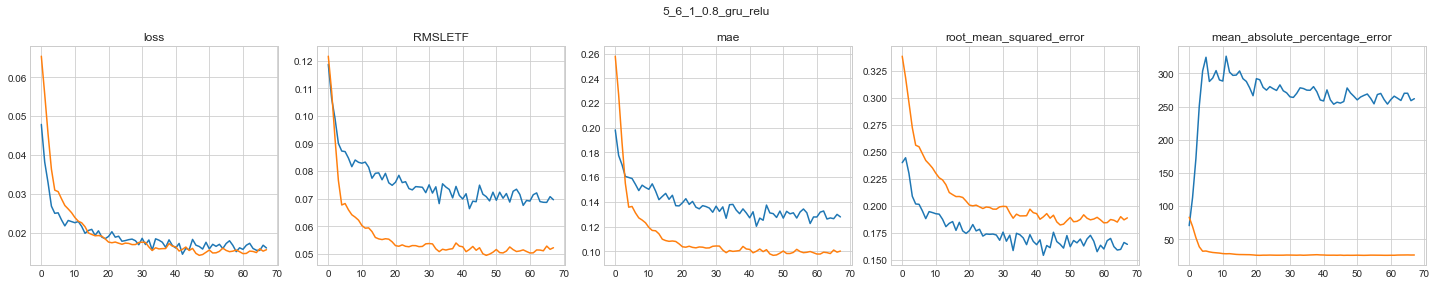

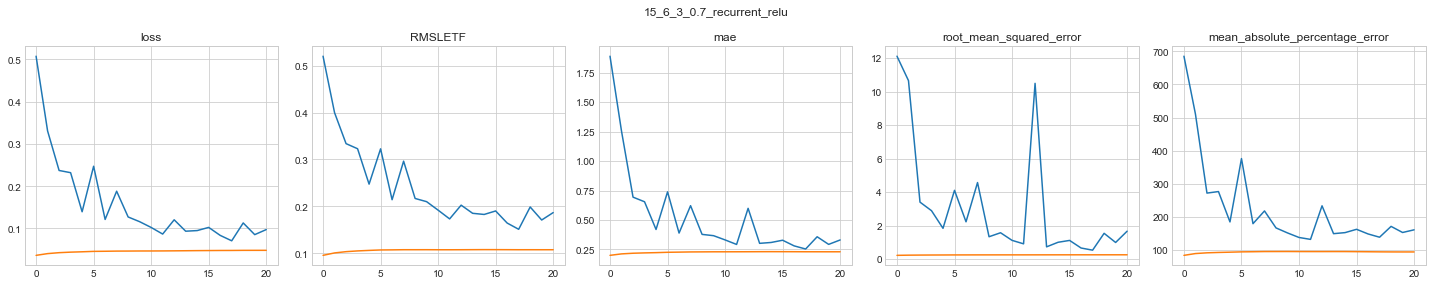

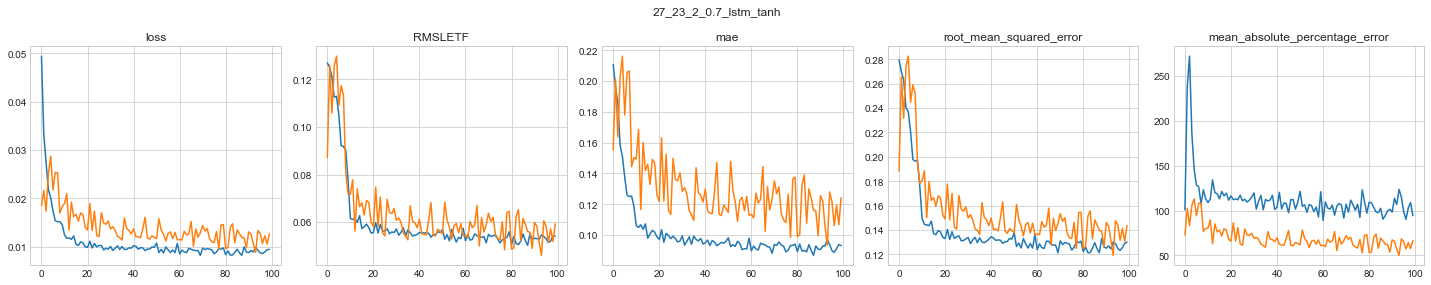

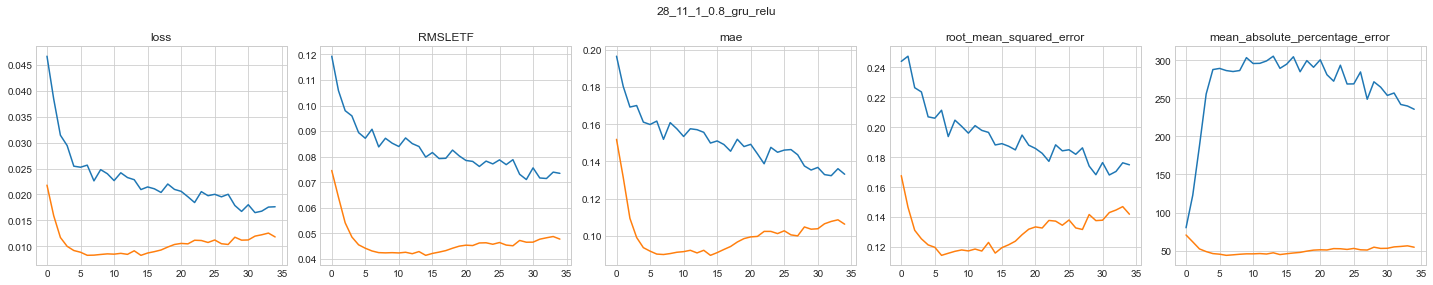

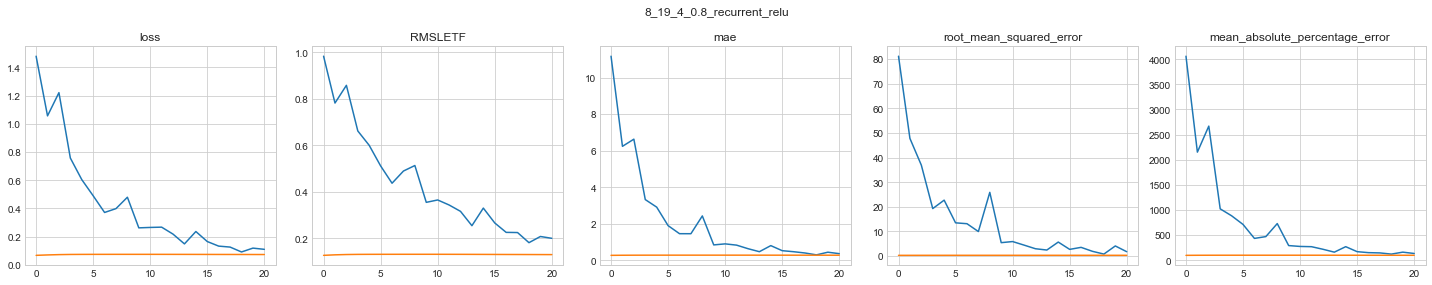

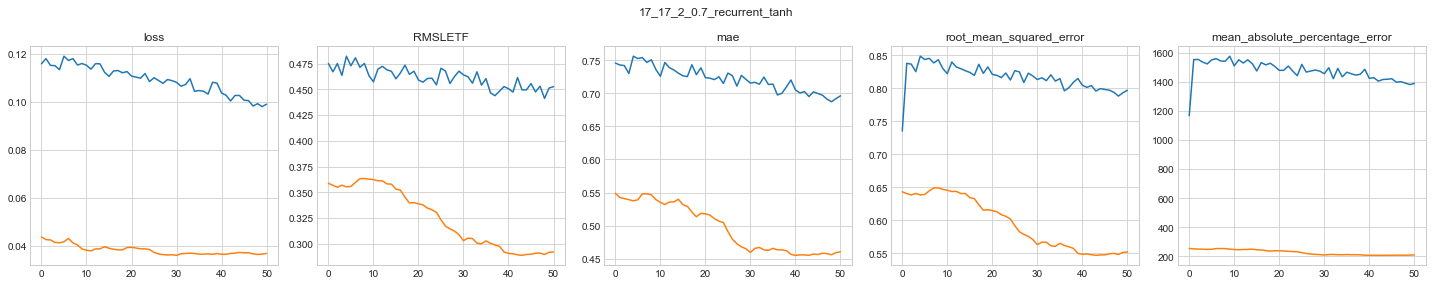

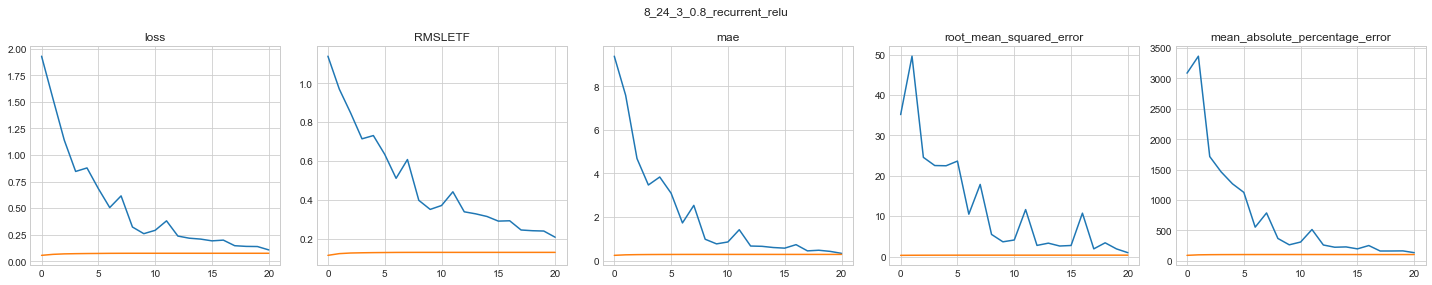

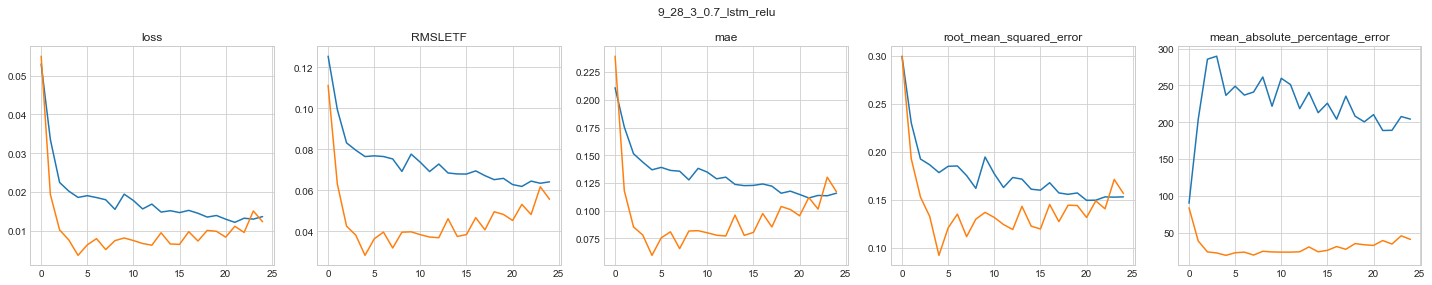

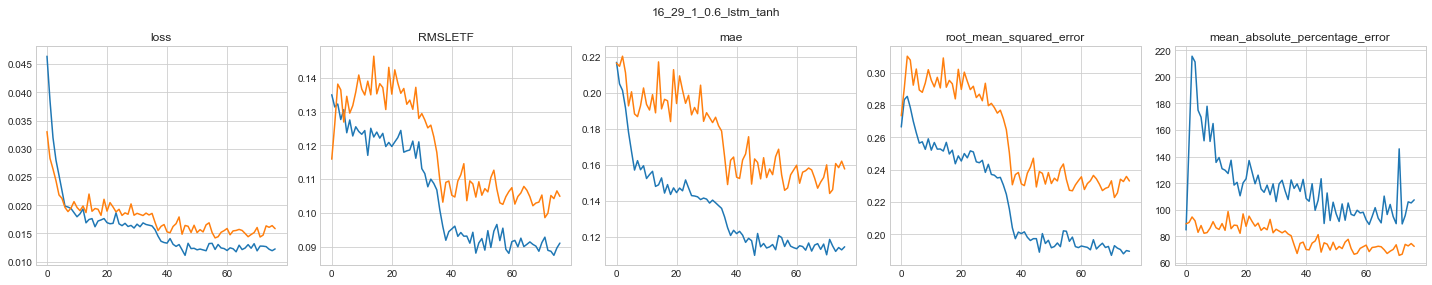

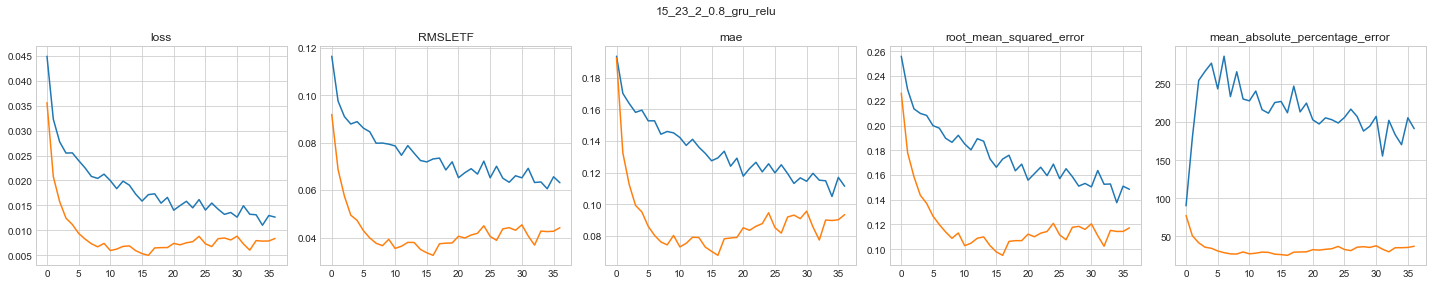

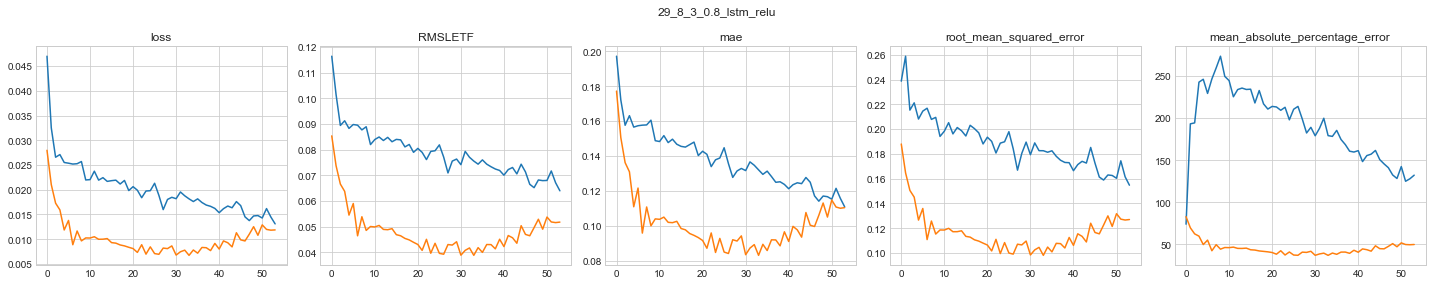

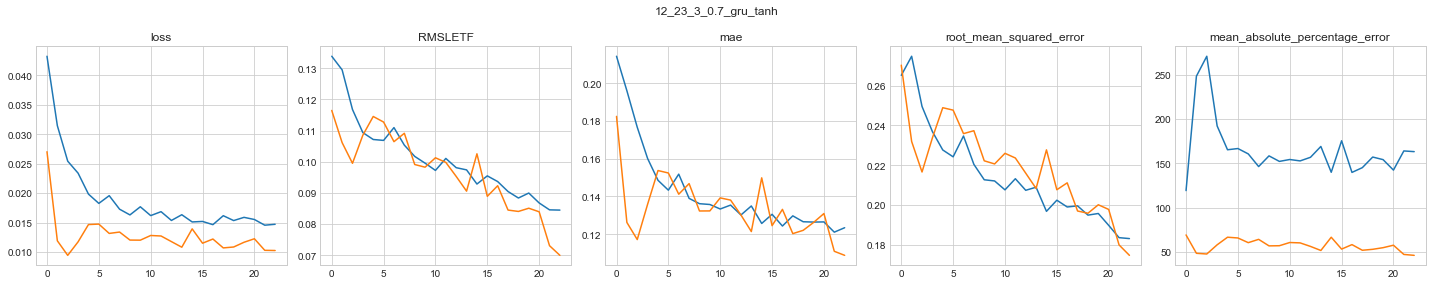

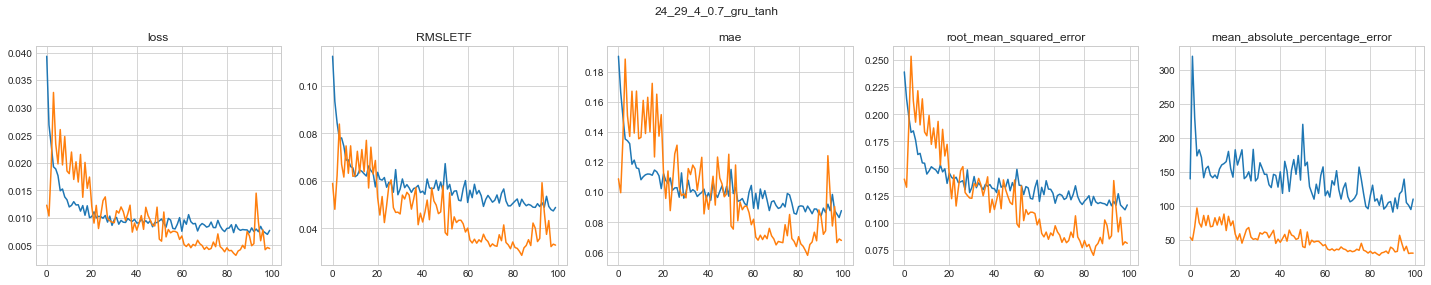

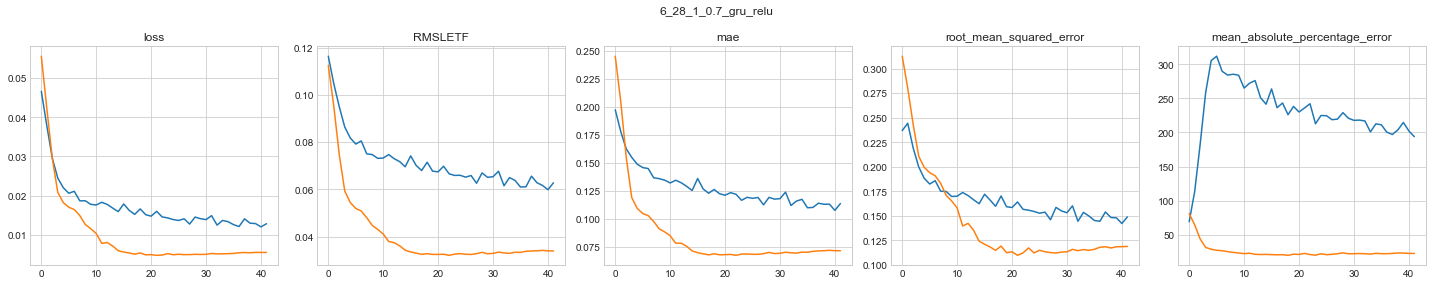

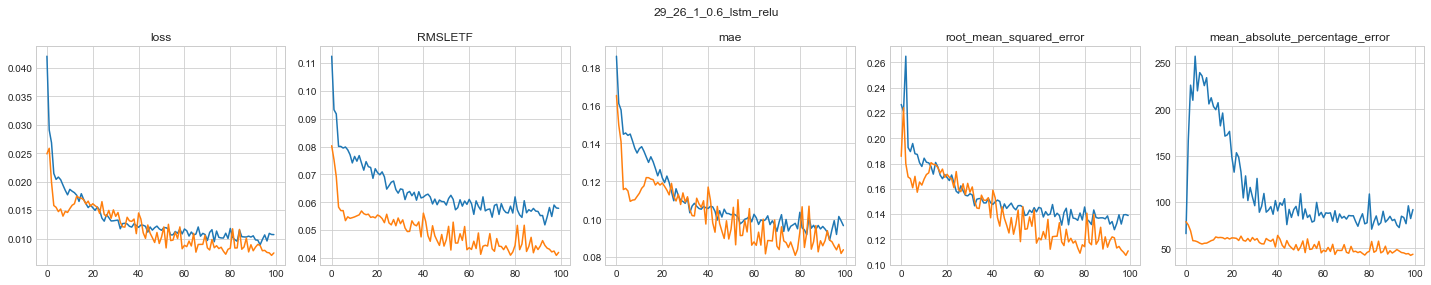

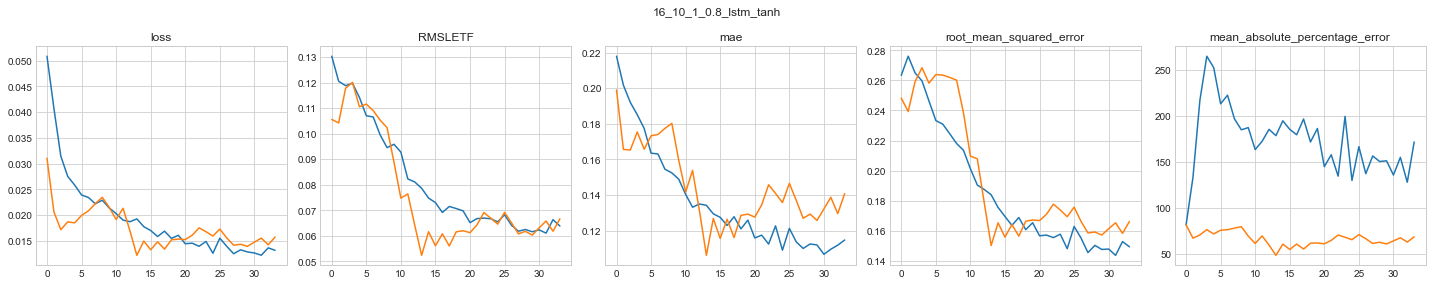

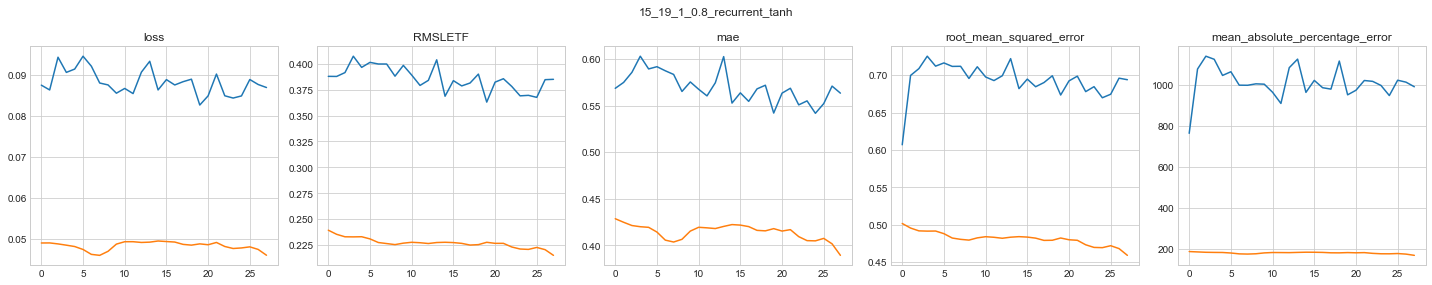

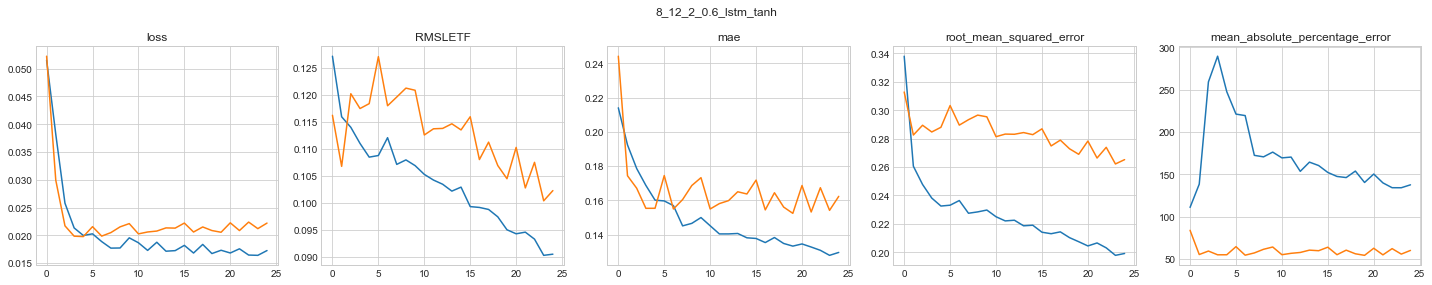

In [10]:
for log_key in parasect.history_log:
    plot_history(log_key, parasect)

In [11]:
# models
parasect.model_log

{'7_29_3_0.8_gru_tanh': <keras.engine.sequential.Sequential at 0x1cca0ffbee0>,
 '18_16_4_0.7_gru_relu': <keras.engine.sequential.Sequential at 0x1ccb1572dc0>,
 '7_6_3_0.7_gru_relu': <keras.engine.sequential.Sequential at 0x1ccb055f190>,
 '29_28_3_0.8_gru_tanh': <keras.engine.sequential.Sequential at 0x1ccbb393c70>,
 '25_28_3_0.6_lstm_tanh': <keras.engine.sequential.Sequential at 0x1ccbb333be0>,
 '21_19_2_0.7_lstm_tanh': <keras.engine.sequential.Sequential at 0x1ccd049ecd0>,
 '13_24_2_0.7_lstm_tanh': <keras.engine.sequential.Sequential at 0x1cce0fb0b80>,
 '17_15_4_0.6_recurrent_tanh': <keras.engine.sequential.Sequential at 0x1cce0f65c70>,
 '27_29_2_0.7_gru_tanh': <keras.engine.sequential.Sequential at 0x1cce7b80550>,
 '19_28_1_0.7_recurrent_relu': <keras.engine.sequential.Sequential at 0x1cce7aa93d0>,
 '11_18_3_0.8_recurrent_relu': <keras.engine.sequential.Sequential at 0x1ccf3c421f0>,
 '15_25_1_0.7_lstm_relu': <keras.engine.sequential.Sequential at 0x1ccf96f24f0>,
 '19_23_2_0.8_gru_rel

In [12]:
model_keys = list(parasect.all_data_from_model.keys())

# model_results = parasect.all_data_from_model['13_4_0.5_13_gru_relu']
# test_forecasts = model_results['test_forecasts']
# test = model_results['Y_test']

# fig = plt.figure(figsize=(12, 5))
# plt.plot(test[:,-1], label='real')
# plt.plot(test_forecasts[:, -1], label='predicted')


# Get best model 


In [55]:
compare_evals = {}
for model_name in model_keys:
    model_results = parasect.all_data_from_model[model_name]
    eval_on_step_14 = model_results['result_test']['test_step_14']
    compare_evals[model_name] = eval_on_step_14

KeyError: '7_29_3_0.8_gru_tanh'

In [20]:
best_models = pd.DataFrame(compare_evals).T.sort_values(by='RMSLE').head()
best_models.style.highlight_min(axis=0)

In [29]:
best_model = best_models.iloc[0].name
# save best model to disk
trained_model = parasect.model_log[best_model]
trained_model.save(os.path.join(path_to_save_models, 'trained_model.h5'))
best_model

'5_5_1_0.7_gru_tanh'

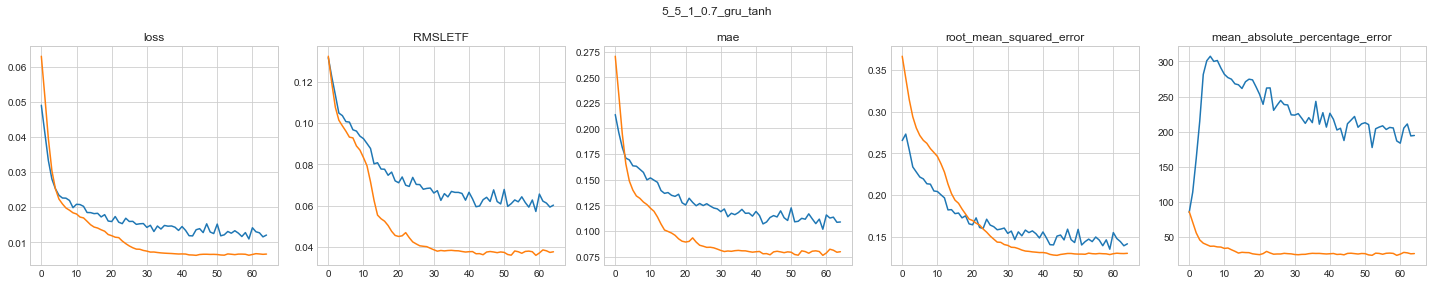

In [31]:
plot_history(best_model)

In [56]:
Y_train, train_preds, Y_val, val_preds, Y_test, test_preds = parasect.get_predictions(trained_model, window_size=5)

6/6 [==============================] - 0s 2ms/step


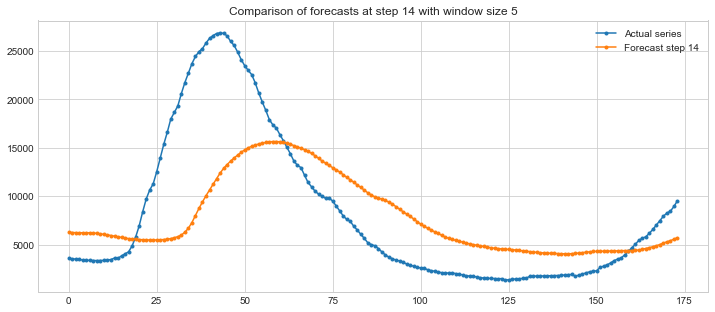

In [61]:
# plot the predictions
fig = plt.figure(figsize=(12, 5))
plt.plot(Y_test[:,-1], marker='.', label='Actual series')
plt.plot(test_preds[:, -1], marker='.', label=f'Forecast step {14}')
plt.title(f'Comparison of forecasts at step {14} with window size {5}')
plt.legend()
plt.show()

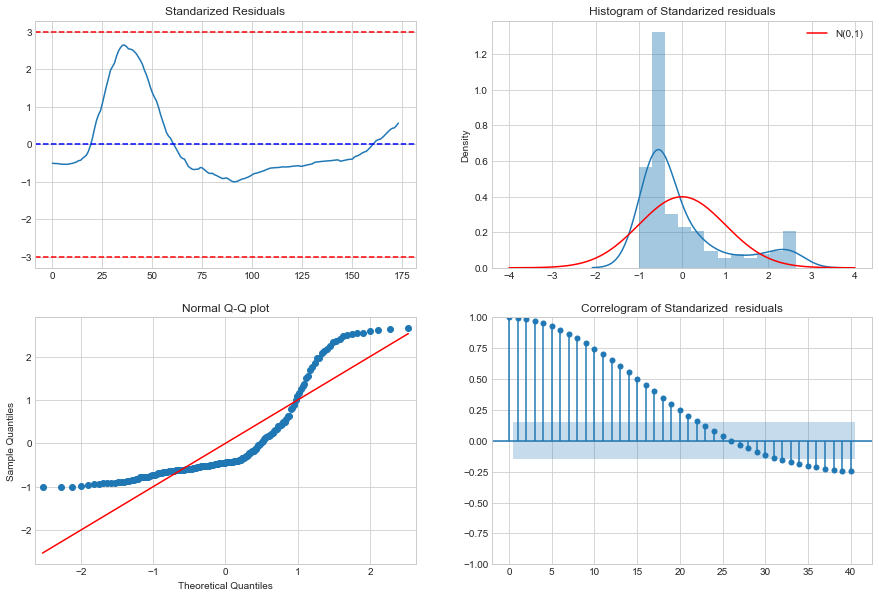

In [62]:
residuals = Y_test[:,-1] - test_preds[:, -1]
diagnostic_checking_residuals(residuals, True)

In [63]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals))

count          mean       std       min       25%       50%      75%  \
0  174.0  4.384709e-08  1.002886 -1.003982 -0.621139 -0.441818  0.27387   

        max  kurtosis  skewness  
0  2.648048  0.902296  1.452409

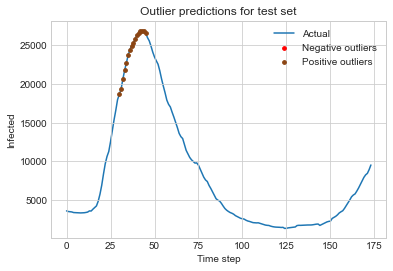

In [69]:
# predicted outliers in the test_ma set
standarized_residuals_test = standarize_residuals(residuals)
outliers_low, = np.where(standarized_residuals_test < -2)
outliers_high, = np.where(standarized_residuals_test > 2)

test = Y_test[:, -1]
plt.plot(test, label='Actual', zorder=0)
plt.scatter(outliers_low, test[outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test[outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for test set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()